First we do some basic stuff, import of data and print some simple stuff

In [1]:
import pandas as pd

df = pd.read_csv("../data/Trips_2018.csv")

In [2]:
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("rows:", len(df))
print("cols:", df.shape[1])
print("memory_mb:", round(df.memory_usage(deep=True).sum()/1_048_576, 2))

print("\ncolumn dtypes:")
print(df.dtypes.sort_index())

print("\nmissing (top 10):")
na = df.isna().sum()
na_pct = (na/len(df)*100).round(2)
missing = pd.DataFrame({"missing": na, "missing_pct": na_pct}).sort_values("missing", ascending=False).head(10)
display(missing)

print("\nunique values (top 10):")
display(df.nunique(dropna=False).sort_values(ascending=False).head(10))

print("\nhead:")
display(df.head(5))


rows: 17548339
cols: 14
memory_mb: 5301.43

column dtypes:
Unnamed: 0                   int64
bikeid                       int64
birth_year                   int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
gender                       int64
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
starttime                   object
stoptime                    object
tripduration                 int64
usertype                    object
dtype: object

missing (top 10):


missing  missing_pct
start_station_id            2497         0.01
end_station_id              2497         0.01
Unnamed: 0                     0         0.00
tripduration                   0         0.00
starttime                      0         0.00
stoptime                       0         0.00
start_station_latitude         0         0.00
start_station_longitude        0         0.00
end_station_latitude           0         0.00
end_station_longitude          0         0.00


unique values (top 10):


Unnamed: 0                 17548339
stoptime                   17539219
starttime                  17539104
tripduration                  30640
bikeid                        15244
end_station_longitude           867
end_station_latitude            862
end_station_id                  851
start_station_longitude         835
start_station_latitude          830
dtype: int64


head:


Unnamed: 0  tripduration                 starttime                  stoptime  start_station_id  \
0           0           970  2018-01-01 13:50:57.4340  2018-01-01 14:07:08.1860              72.0   
1           1           723  2018-01-01 15:33:30.1820  2018-01-01 15:45:33.3410              72.0   
2           2           496  2018-01-01 15:39:18.3370  2018-01-01 15:47:35.1720              72.0   
3           3           306  2018-01-01 15:40:13.3720  2018-01-01 15:45:20.1910              72.0   
4           4           306  2018-01-01 18:14:51.5680  2018-01-01 18:19:57.6420              72.0   

   start_station_latitude  start_station_longitude  end_station_id  end_station_latitude  end_station_longitude  \
0               40.767272               -73.993929           505.0             40.749013             -73.988484   
1               40.767272               -73.993929          3255.0             40.750585             -73.994685   
2               40.767272               -73.993929           525.0             40.755942             -74.002116   
3               40.767272               -73.993929           447.0             40.763707             -73.985162   
4               40.767272               -73.993929          3356.0             40.774667             -73.984706   

   bikeid    usertype  birth_year  gender  
0   31956  Subscriber        1992       1  
1   32536  Subscriber        1969       1  
2   16069  Subscriber        1956       1  
3   31781  Subscriber        1974       1  
4   30319  Subscriber        1992       1

Next, I will try to add some weather data, event data and holiday data to see if this influence the number of bike rides

In [16]:
import pandas as pd, numpy as np, re
from IPython.display import display

path_daily = "/Users/andreas/BusinessAnalytics1/business-analytics1-project/data/daily-summaries-2025-10-29T10-43-40.csv"
path_hourly = "/Users/andreas/BusinessAnalytics1/business-analytics1-project/data/local-climatological-data-2025-10-29T10-44-24.csv"

def num(x):
    if x is None or (isinstance(x,float) and np.isnan(x)): return np.nan
    s = str(x).strip()
    if s in {"M",""}: return np.nan
    if s == "T": return 0.0
    s = re.sub(r"[^0-9\.\-]+","",s)
    return float(s) if s not in {"","-"} else np.nan

def lcmap(cols):
    return {c:c for c in cols}, {c.lower():c for c in cols}

def pick_col(df, cands):
    _, low = lcmap(df.columns)
    for c in cands:
        if c in df.columns: return c
        if c.lower() in low: return low[c.lower()]
    return None

def avail_table(df, groups):
    rows = []
    for name, cands in groups.items():
        col = pick_col(df, cands)
        nn = int(df[col].notna().sum()) if col else 0
        ex = ", ".join(df[col].dropna().astype(str).head(3).tolist()) if col else ""
        rows.append((name, col, nn, ex))
    return pd.DataFrame(rows, columns=["field","column","non_null","examples"])

wx_d_raw = pd.read_csv(path_daily, dtype=str, low_memory=False)
wx_h_raw = pd.read_csv(path_hourly, dtype=str, low_memory=False)

print("DAILY WEATHER: shape, columns")
print(wx_d_raw.shape)
display(pd.DataFrame({"columns": wx_d_raw.columns}))

print("HOURLY WEATHER: shape, columns")
print(wx_h_raw.shape)
display(pd.DataFrame({"columns": wx_h_raw.columns}))

dcol_d = pick_col(wx_d_raw, ["DATE","Time","DATE_TIME","time","date"])
wx_d = wx_d_raw.copy()
wx_d["date"] = pd.to_datetime(wx_d[dcol_d], errors="coerce").dt.tz_localize(None).dt.normalize()

dcol_h = pick_col(wx_h_raw, ["DATE","DATE_TIME","HOURLYDATETIME","time","datetime","date"])
wx_h = wx_h_raw.copy()
wx_h["datetime"] = pd.to_datetime(wx_h[dcol_h], errors="coerce").dt.tz_localize(None)
wx_h = wx_h.dropna(subset=["datetime"])
wx_h["date"] = wx_h["datetime"].dt.normalize()

print("DAILY WEATHER date range and non-nulls")
display(pd.DataFrame({
    "min_date":[wx_d["date"].min()], "max_date":[wx_d["date"].max()],
    "rows":[len(wx_d)], "unique_dates":[wx_d["date"].nunique()]
}))
print("HOURLY WEATHER date range and non-nulls")
display(pd.DataFrame({
    "min_datetime":[wx_h["datetime"].min()], "max_datetime":[wx_h["datetime"].max()],
    "rows":[len(wx_h)], "unique_dates":[wx_h["date"].nunique()]
}))

daily_groups = {
    "tavg":["TAVG","tavg","AVG_TEMPERATURE"],
    "tmin":["TMIN","tmin"],
    "tmax":["TMAX","tmax"],
    "prcp":["PRCP","prcp","PRECIPITATION"],
    "snow":["SNOW","snow"],
    "snwd":["SNWD","snwd"]
}
hourly_groups = {
    "temp":["HourlyDryBulbTemperature","DryBulbTemperature","DryBulbTemp","HourlyDryBulbTempF","DryBulbTempF","HourlyDryBulbTempC","DryBulbTempC"],
    "precip":["HourlyPrecipitation","HourlyPrecip","Precipitation","HourlyPrecipitationAmount"],
    "wspd":["HourlyWindSpeed","WindSpeed"],
    "wgst":["HourlyWindGust","HourlyWindGustSpeed","WindGust","WindGustSpeed"],
    "rh":["HourlyRelativeHumidity","RelativeHumidity"]
}

print("DAILY WEATHER field availability")
avail_d = avail_table(wx_d_raw, daily_groups)
display(avail_d)

print("HOURLY WEATHER field availability")
avail_h = avail_table(wx_h_raw, hourly_groups)
display(avail_h)

print("DAILY WEATHER sample (first 5 rows)")
display(wx_d_raw.head(5))
print("HOURLY WEATHER sample (first 5 rows, selected)")
sel_h = [c for c in wx_h_raw.columns if c in avail_h["column"].dropna().tolist()] or wx_h_raw.columns.tolist()[:8]
display(wx_h_raw[sel_h].head(5))

tavg_col = pick_col(wx_d_raw, daily_groups["tavg"])
tmin_col = pick_col(wx_d_raw, daily_groups["tmin"])
tmax_col = pick_col(wx_d_raw, daily_groups["tmax"])
prcp_col = pick_col(wx_d_raw, daily_groups["prcp"])
snow_col = pick_col(wx_d_raw, daily_groups["snow"])
snwd_col = pick_col(wx_d_raw, daily_groups["snwd"])

wx_d_num = wx_d[["date"]].copy()
for c,name in [(tavg_col,"tavg"),(tmin_col,"tmin"),(tmax_col,"tmax"),(prcp_col,"prcp"),(snow_col,"snow"),(snwd_col,"snwd")]:
    if c:
        wx_d_num[name] = wx_d_raw[c].map(num)
wx_d_num = wx_d_num.drop_duplicates("date")

print("DAILY WEATHER numeric summary")
display(wx_d_num.describe(include="all").T)

temp_col_h = pick_col(wx_h_raw, hourly_groups["temp"])
prec_col_h = pick_col(wx_h_raw, hourly_groups["precip"])
wspd_col_h = pick_col(wx_h_raw, hourly_groups["wspd"])
wgst_col_h = pick_col(wx_h_raw, hourly_groups["wgst"])
rh_col_h = pick_col(wx_h_raw, hourly_groups["rh"])

wx_h_num = wx_h[["date","datetime"]].copy()
if temp_col_h: wx_h_num["temp"] = wx_h_raw.loc[wx_h.index, temp_col_h].map(num).values
if prec_col_h: wx_h_num["precip"] = wx_h_raw.loc[wx_h.index, prec_col_h].map(num).values
if wspd_col_h: wx_h_num["wspd"] = wx_h_raw.loc[wx_h.index, wspd_col_h].map(num).values
if wgst_col_h: wx_h_num["wgst"] = wx_h_raw.loc[wx_h.index, wgst_col_h].map(num).values
if rh_col_h:   wx_h_num["rh"]   = wx_h_raw.loc[wx_h.index, rh_col_h].map(num).values

print("HOURLY WEATHER numeric summary (hourly)")
display(wx_h_num.drop(columns=["date","datetime"]).describe(include="all").T)

wxh_daily = wx_h_num.groupby("date").agg(
    temp_mean=("temp","mean") if "temp" in wx_h_num else ("datetime","size"),
    precip_sum=("precip","sum") if "precip" in wx_h_num else ("datetime","size"),
    wspd_mean=("wspd","mean") if "wspd" in wx_h_num else ("datetime","size"),
    wgst_max=("wgst","max") if "wgst" in wx_h_num else ("datetime","size"),
    rh_mean=("rh","mean") if "rh" in wx_h_num else ("datetime","size")
).reset_index()

print("HOURLY→DAILY aggregation sample")
display(wxh_daily.head(10))

trip_daily = (df.assign(starttime=pd.to_datetime(df["starttime"], errors="coerce"))
                .dropna(subset=["starttime"])
                .assign(date=lambda d: d["starttime"].dt.normalize())
                .groupby("date").size().rename("trips").reset_index())

print("TRIPS daily coverage")
display(pd.DataFrame({
    "min_date":[trip_daily["date"].min()], "max_date":[trip_daily["date"].max()],
    "days":[len(trip_daily)], "total_trips":[int(trip_daily["trips"].sum())]
}))

Xd = trip_daily.merge(wx_d_num, on="date", how="left")
Xh = trip_daily.merge(wxh_daily, on="date", how="left")

print("MERGE with DAILY WEATHER: rows and nulls")
display(pd.DataFrame({
    "rows":[len(Xd)],
    "tavg_non_null":[Xd["tavg"].notna().sum() if "tavg" in Xd else 0],
    "prcp_non_null":[Xd["prcp"].notna().sum() if "prcp" in Xd else 0],
    "snow_non_null":[Xd["snow"].notna().sum() if "snow" in Xd else 0]
}))

print("MERGE with HOURLY AGG: rows and nulls")
display(pd.DataFrame({
    "rows":[len(Xh)],
    "temp_mean_non_null":[Xh["temp_mean"].notna().sum() if "temp_mean" in Xh else 0],
    "precip_sum_non_null":[Xh["precip_sum"].notna().sum() if "precip_sum" in Xh else 0],
    "wspd_mean_non_null":[Xh["wspd_mean"].notna().sum() if "wspd_mean" in Xh else 0],
    "wgst_max_non_null":[Xh["wgst_max"].notna().sum() if "wgst_max" in Xh else 0],
    "rh_mean_non_null":[Xh["rh_mean"].notna().sum() if "rh_mean" in Xh else 0]
}))

print("First 10 rows of MERGE with DAILY WEATHER")
cols_d_show = ["date","trips"] + [c for c in ["tavg","tmin","tmax","prcp","snow","snwd"] if c in Xd.columns]
display(Xd[cols_d_show].head(10))

print("First 10 rows of MERGE with HOURLY AGG")
cols_h_show = ["date","trips"] + [c for c in ["temp_mean","precip_sum","wspd_mean","wgst_max","rh_mean"] if c in Xh.columns]
display(Xh[cols_h_show].head(10))


DAILY WEATHER: shape, columns
(365, 151)


columns
0         STATION
1            DATE
2            ACMC
3            ACMH
4            ACSC
..            ...
146          WV20
147           alt
148  station_info
149  station_name
150          time

[151 rows x 1 columns]

HOURLY WEATHER: shape, columns
(0, 124)


columns
0                               STATION
1                                  DATE
2                           REPORT_TYPE
3                                SOURCE
4                                  AWND
..                                  ...
119  ShortDurationPrecipitationValue150
120  ShortDurationPrecipitationValue180
121                             Sunrise
122                              Sunset
123             WindEquipmentChangeDate

[124 rows x 1 columns]

DAILY WEATHER date range and non-nulls


min_date   max_date  rows  unique_dates
0 2018-01-01 2018-12-31   365           365

HOURLY WEATHER date range and non-nulls


min_datetime max_datetime  rows  unique_dates
0          NaT          NaT     0             0

DAILY WEATHER field availability


field column  non_null             examples
0  tavg   TAVG         0                     
1  tmin   TMIN       365   -138,  -105,   -88
2  tmax   TMAX       365    -71,   -32,   -10
3  prcp   PRCP       365      0,     0,     0
4  snow   SNOW       365      0,     0,     0
5  snwd   SNWD       365      0,     0,     0

HOURLY WEATHER field availability


field                    column  non_null examples
0    temp  HourlyDryBulbTemperature         0         
1  precip       HourlyPrecipitation         0         
2    wspd           HourlyWindSpeed         0         
3    wgst       HourlyWindGustSpeed         0         
4      rh    HourlyRelativeHumidity         0

DAILY WEATHER sample (first 5 rows)


STATION        DATE ACMC ACMH ACSC ACSH   ADPT   ASLP   ASTP   AWBT AWDR   AWND DAEV DAPR DASF DATN DATX DAWM  \
0  USW00094728  2018-01-01  NaN  NaN  NaN  NaN   -194  10278  10224   -122  NaN     35  NaN  NaN  NaN  NaN  NaN  NaN   
1  USW00094728  2018-01-02  NaN  NaN  NaN  NaN   -156  10278  10227    -94  NaN     36  NaN  NaN  NaN  NaN  NaN  NaN   
2  USW00094728  2018-01-03  NaN  NaN  NaN  NaN   -161  10237  10196    -78  NaN     14  NaN  NaN  NaN  NaN  NaN  NaN   
3  USW00094728  2018-01-04  NaN  NaN  NaN  NaN    -94   9990   9925    -61  NaN     56  NaN  NaN  NaN  NaN  NaN  NaN   
4  USW00094728  2018-01-05  NaN  NaN  NaN  NaN   -206  10098  10030   -128  NaN     58  NaN  NaN  NaN  NaN  NaN  NaN   

  DWPR EVAP FMTM FRGB FRGT FRTH GAHT MDEV MDPR MDSF MDTN MDTX MDWM MNPN MXPN PGTM   PRCP PSUN   RHAV   RHMN   RHMX  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      0  NaN     48     34     60   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      0  NaN     52     42     62   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      0  NaN     42     28     51   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    193  NaN     70     39     92   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      0  NaN     43     33     56   

  SN01 SN02 SN03 SN11 SN12 SN13 SN14 SN21 SN22 SN23 SN31 SN32 SN33 SN34 SN35 SN36 SN51 SN52 SN53 SN54 SN55 SN56 SN57  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  SN61 SN72 SN81 SN82 SN83   SNOW   SNWD SX01 SX02 SX03 SX11 SX12 SX13 SX14 SX15 SX17 SX21 SX22 SX23 SX31 SX32 SX33  \
0  NaN  NaN  NaN  NaN  NaN      0      0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN      0      0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN      0      0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN    249     30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN      0    180  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  SX34 SX35 SX36 SX51 SX52 SX53 SX54 SX55 SX56 SX57 SX61 SX72 SX81 SX82 SX83 TAVG TAXN THIC   TMAX   TMIN TOBS TSUN  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    -71   -138  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    -32   -105  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    -10    -88  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    -16    -71  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    -71   -127  NaN  NaN   

  WDF1   WDF2   WDF5 WDFG WDFI WDFM WDMV WESD WESF WSF1   WSF2   WSF5 WSFG WSFI WSFM   WT01   WT02 WT03 WT04 WT05  \
0  NaN    300    300  NaN  NaN  NaN  NaN  NaN  NaN  NaN     67    112  NaN  NaN  NaN    NaN    NaN  NaN  NaN  NaN   
1  NaN    260    250  NaN  NaN  NaN  NaN  NaN  NaN  NaN     72    125  NaN  NaN  NaN    NaN    NaN  NaN  NaN  NaN   
2  NaN    260    270  NaN  NaN  NaN  NaN  NaN  NaN  NaN     63     98  NaN 

HOURLY WEATHER sample (first 5 rows, selected)


Empty DataFrame
Columns: [HourlyDryBulbTemperature, HourlyPrecipitation, HourlyRelativeHumidity, HourlyWindGustSpeed, HourlyWindSpeed]
Index: []

DAILY WEATHER numeric summary


count                 mean                  min                  25%                  50%                  75%  \
date    365  2018-07-02 00:00:00  2018-01-01 00:00:00  2018-04-02 00:00:00  2018-07-02 00:00:00  2018-10-01 00:00:00   
tavg    0.0                  NaN                  NaN                  NaN                  NaN                  NaN   
tmin  365.0            96.068493               -149.0                 17.0                 83.0                189.0   
tmax  365.0           170.273973               -105.0                 83.0                167.0                261.0   
prcp  365.0            45.624658                  0.0                  0.0                  0.0                 28.0   
snow  365.0             2.758904                  0.0                  0.0                  0.0                  0.0   
snwd  365.0             4.575342                  0.0                  0.0                  0.0                  0.0   

                      max         std  
date  2018-12-31 00:00:00         NaN  
tavg                  NaN         NaN  
tmin                272.0   96.376284  
tmax                356.0  102.226405  
prcp                737.0   101.52128  
snow                249.0   21.521315  
snwd                200.0   23.815867

HOURLY WEATHER numeric summary (hourly)


count unique  top freq
temp       0      0  NaN  NaN
precip     0      0  NaN  NaN
wspd       0      0  NaN  NaN
wgst       0      0  NaN  NaN
rh         0      0  NaN  NaN

HOURLY→DAILY aggregation sample


Empty DataFrame
Columns: [date, temp_mean, precip_sum, wspd_mean, wgst_max, rh_mean]
Index: []

TRIPS daily coverage


min_date   max_date  days  total_trips
0 2018-01-01 2018-12-31   365     17548339

MERGE with DAILY WEATHER: rows and nulls


rows  tavg_non_null  prcp_non_null  snow_non_null
0   365              0            365            365

MERGE with HOURLY AGG: rows and nulls


rows  temp_mean_non_null  precip_sum_non_null  wspd_mean_non_null  wgst_max_non_null  rh_mean_non_null
0   365                   0                    0                   0                  0                 0

First 10 rows of MERGE with DAILY WEATHER


date  trips  tavg   tmin   tmax   prcp   snow   snwd
0 2018-01-01   5500   NaN -138.0  -71.0    0.0    0.0    0.0
1 2018-01-02  18818   NaN -105.0  -32.0    0.0    0.0    0.0
2 2018-01-03  24299   NaN  -88.0  -10.0    0.0    0.0    0.0
3 2018-01-04   1922   NaN  -71.0  -16.0  193.0  249.0   30.0
4 2018-01-05   4972   NaN -127.0  -71.0    0.0    0.0  180.0
5 2018-01-06   4295   NaN -143.0 -105.0    0.0    0.0  150.0
6 2018-01-07   5640   NaN -149.0  -77.0    0.0    0.0  150.0
7 2018-01-08  15821   NaN  -82.0   -5.0    3.0    0.0  130.0
8 2018-01-09  25091   NaN  -10.0   67.0    0.0    0.0  130.0
9 2018-01-10  28252   NaN  -10.0   61.0    0.0    0.0  100.0

First 10 rows of MERGE with HOURLY AGG


date  trips temp_mean precip_sum wspd_mean wgst_max rh_mean
0 2018-01-01   5500       NaN        NaN       NaN      NaN     NaN
1 2018-01-02  18818       NaN        NaN       NaN      NaN     NaN
2 2018-01-03  24299       NaN        NaN       NaN      NaN     NaN
3 2018-01-04   1922       NaN        NaN       NaN      NaN     NaN
4 2018-01-05   4972       NaN        NaN       NaN      NaN     NaN
5 2018-01-06   4295       NaN        NaN       NaN      NaN     NaN
6 2018-01-07   5640       NaN        NaN       NaN      NaN     NaN
7 2018-01-08  15821       NaN        NaN       NaN      NaN     NaN
8 2018-01-09  25091       NaN        NaN       NaN      NaN     NaN
9 2018-01-10  28252       NaN        NaN       NaN      NaN     NaN

In [17]:
import pandas as pd, numpy as np
from IPython.display import display

path_daily = "/Users/andreas/BusinessAnalytics1/business-analytics1-project/data/daily-summaries-2025-10-29T10-43-40.csv"

def pick(df, names):
    m = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return n
        if n.lower() in m: return m[n.lower()]
    return None

wx_raw = pd.read_csv(path_daily, dtype=str, low_memory=False)
date_col = pick(wx_raw, ["DATE","date","time"])
tmin_col = pick(wx_raw, ["TMIN"])
tmax_col = pick(wx_raw, ["TMAX"])
prcp_col = pick(wx_raw, ["PRCP"])
snow_col = pick(wx_raw, ["SNOW"])
snwd_col = pick(wx_raw, ["SNWD"])

wx = pd.DataFrame({"date": pd.to_datetime(wx_raw[date_col], errors="coerce").dt.normalize()})
wx["tmin_c"] = pd.to_numeric(wx_raw[tmin_col], errors="coerce")/10.0
wx["tmax_c"] = pd.to_numeric(wx_raw[tmax_col], errors="coerce")/10.0
wx["tavg_c"] = wx[["tmin_c","tmax_c"]].mean(axis=1)
wx["prcp_mm"] = pd.to_numeric(wx_raw[prcp_col], errors="coerce")/10.0
wx["snow_mm"] = pd.to_numeric(wx_raw[snow_col], errors="coerce")
wx["snwd_mm"] = pd.to_numeric(wx_raw[snwd_col], errors="coerce")
wx = wx.dropna(subset=["date"]).drop_duplicates("date").sort_values("date").reset_index(drop=True)

trip_daily = (df.assign(starttime=pd.to_datetime(df["starttime"], errors="coerce"),
                        tripduration=pd.to_numeric(df["tripduration"], errors="coerce"))
                .dropna(subset=["starttime"])
                .assign(date=lambda d: d["starttime"].dt.normalize())
                .groupby("date")
                .agg(trips=("starttime","size"), hours=("tripduration", lambda s: s.fillna(0).sum()/3600.0))
                .reset_index())

X = trip_daily.merge(wx, on="date", how="left")

coverage = pd.DataFrame({
    "rows":[len(X)],
    "non_null_tavg_c":[X["tavg_c"].notna().sum()],
    "non_null_prcp_mm":[X["prcp_mm"].notna().sum()],
    "non_null_snow_mm":[X["snow_mm"].notna().sum()],
    "non_null_snwd_mm":[X["snwd_mm"].notna().sum()]
})

X["rain"] = X["prcp_mm"].fillna(0) > 0
X["snow_day"] = X["snow_mm"].fillna(0) > 0
X["tbin"] = pd.cut(X["tavg_c"], [-50,-5,0,5,10,15,20,25,30,60], right=False)
X["pbin"] = pd.cut(X["prcp_mm"].fillna(0), [-0.01,0,2,10,25,1000], labels=["0 mm","0–2","2–10","10–25",">25"])

summary_basic = pd.DataFrame({
    "days":[len(X)],
    "total_trips":[int(X["trips"].sum())],
    "avg_daily_trips":[round(X["trips"].mean(),1)],
    "avg_daily_hours":[round(X["hours"].mean(),2)]
}).T.rename(columns={0:"value"})

by_rain = X.groupby("rain")[["trips","hours"]].mean().rename(index={False:"dry", True:"rain"}).round(2)
by_snow = X.groupby("snow_day")[["trips","hours"]].mean().rename(index={False:"no_snow", True:"snow"}).round(2)
by_tbin = X.groupby("tbin")[["trips","hours"]].mean().round(2).reset_index()
by_pbin = X.groupby("pbin")[["trips","hours"]].mean().round(2).reset_index()

top_rain = X.sort_values("prcp_mm", ascending=False)[["date","trips","hours","tavg_c","prcp_mm","snow_mm","snwd_mm"]].head(10)
top_snow = X.sort_values("snow_mm", ascending=False)[["date","trips","hours","tavg_c","prcp_mm","snow_mm","snwd_mm"]].head(10)
cold_hot = pd.concat([
    X.sort_values("tavg_c").head(5)[["date","trips","hours","tavg_c","prcp_mm"]],
    X.sort_values("tavg_c", ascending=False).head(5)[["date","trips","hours","tavg_c","prcp_mm"]]
]).reset_index(drop=True)

corr = X[["trips","hours","tavg_c","prcp_mm","snow_mm","snwd_mm"]].corr(method="pearson").round(3)

print("COVERAGE")
display(coverage)
print("MERGED DAILY (first 10)")
display(X.head(10))
print("BASIC SUMMARY")
display(summary_basic)
print("TRIPS/HOURS: DRY VS RAIN")
display(by_rain)
print("TRIPS/HOURS: SNOW VS NO-SNOW")
display(by_snow)
print("TRIPS/HOURS BY TEMPERATURE BIN (°C)")
display(by_tbin)
print("TRIPS/HOURS BY PRECIP BIN (mm)")
display(by_pbin)
print("TOP 10 RAINIEST DAYS")
display(top_rain)
print("TOP 10 SNOWIEST DAYS")
display(top_snow)
print("COLDEST 5 AND HOTTEST 5 DAYS")
display(cold_hot)
print("CORRELATIONS")
display(corr)


COVERAGE


rows  non_null_tavg_c  non_null_prcp_mm  non_null_snow_mm  non_null_snwd_mm
0   365              365               365               365               365

MERGED DAILY (first 10)


date  trips        hours  tmin_c  tmax_c  tavg_c  prcp_mm  snow_mm  snwd_mm   rain  snow_day       tbin   pbin
0 2018-01-01   5500  1904.081667   -13.8    -7.1  -10.45      0.0        0        0  False     False  [-50, -5)   0 mm
1 2018-01-02  18818  3557.833056   -10.5    -3.2   -6.85      0.0        0        0  False     False  [-50, -5)   0 mm
2 2018-01-03  24299  4540.226667    -8.8    -1.0   -4.90      0.0        0        0  False     False    [-5, 0)   0 mm
3 2018-01-04   1922   555.086667    -7.1    -1.6   -4.35     19.3      249       30   True      True    [-5, 0)  10–25
4 2018-01-05   4972  1339.196389   -12.7    -7.1   -9.90      0.0        0      180  False     False  [-50, -5)   0 mm
5 2018-01-06   4295  2133.593056   -14.3   -10.5  -12.40      0.0        0      150  False     False  [-50, -5)   0 mm
6 2018-01-07   5640  1199.681389   -14.9    -7.7  -11.30      0.0        0      150  False     False  [-50, -5)   0 mm
7 2018-01-08  15821  4592.619722    -8.2    -0.5   -4.35      0.3        0      130   True     False    [-5, 0)    0–2
8 2018-01-09  25091  5476.098333    -1.0     6.7    2.85      0.0        0      130  False     False     [0, 5)   0 mm
9 2018-01-10  28252  5588.950278    -1.0     6.1    2.55      0.0        0      100  False     False     [0, 5)   0 mm

BASIC SUMMARY


value
days                  365.00
total_trips      17548339.00
avg_daily_trips     48077.60
avg_daily_hours     13204.57

TRIPS/HOURS: DRY VS RAIN


trips     hours
rain                    
dry   51757.13  14644.53
rain  43257.05  11318.03

TRIPS/HOURS: SNOW VS NO-SNOW


trips     hours
snow_day                    
no_snow   48992.51  13494.80
snow      18635.36   3864.27

TRIPS/HOURS BY TEMPERATURE BIN (°C)


tbin     trips     hours
0  [-50, -5)   8620.29   2493.63
1    [-5, 0)  23931.12   4892.87
2     [0, 5)  30906.18   6870.16
3    [5, 10)  37927.09   8955.64
4   [10, 15)  44476.24  11772.09
5   [15, 20)  60728.98  17828.35
6   [20, 25)  65004.12  19419.78
7   [25, 30)  64413.02  19473.37
8   [30, 60)  59099.25  16080.17

TRIPS/HOURS BY PRECIP BIN (mm)


pbin     trips     hours
0   0 mm  51757.13  14644.53
1    0–2  47771.41  12704.12
2   2–10  47649.20  12360.30
3  10–25  39066.19  10371.28
4    >25  27040.21   6484.50

TOP 10 RAINIEST DAYS


date  trips         hours  tavg_c  prcp_mm  snow_mm  snwd_mm
222 2018-08-11  36607  10682.983056   23.90     73.7        0        0
105 2018-04-16  26289   5985.221944    9.75     71.6        0        0
197 2018-07-17  48497  12637.551389   26.10     56.9        0        0
267 2018-09-25  25421   5252.799167   18.90     49.5        0        0
60  2018-03-02   6855   1536.923611    3.90     47.2        0        0
354 2018-12-21  23696   5001.715278   12.20     40.9        0        0
349 2018-12-16   9746   1982.511667    4.75     36.3        0        0
65  2018-03-07   8188   1412.612222    2.25     35.8       81        0
178 2018-06-28  50433  13008.436667   24.70     34.5        0        0
299 2018-10-27  13000   2449.287222    8.65     32.3        0        0

TOP 10 SNOWIEST DAYS


date  trips        hours  tavg_c  prcp_mm  snow_mm  snwd_mm
3   2018-01-04   1922   555.086667   -4.35     19.3      249       30
79  2018-03-21   3755   763.078889    1.70     25.1      208        0
318 2018-11-15  24738  5400.144722    1.15     29.5      163        0
91  2018-04-02  22063  6029.727778    3.35     15.0      140      130
47  2018-02-17  17921  4532.886389    1.15     13.2      112        0
65  2018-03-07   8188  1412.612222    2.25     35.8       81        0
29  2018-01-30  27996  5094.478056   -1.05      2.8       23        0
37  2018-02-07  15289  2698.075833    3.10     21.6       13        0
16  2018-01-17  19010  3292.647222   -1.65      4.8       10        0
80  2018-03-22  27308  5379.972778    5.00      1.5        5      200

COLDEST 5 AND HOTTEST 5 DAYS


date  trips         hours  tavg_c  prcp_mm
0 2018-01-06   4295   2133.593056  -12.40      0.0
1 2018-01-07   5640   1199.681389  -11.30      0.0
2 2018-01-01   5500   1904.081667  -10.45      0.0
3 2018-01-05   4972   1339.196389   -9.90      0.0
4 2018-01-02  18818   3557.833056   -6.85      0.0
5 2018-07-01  45266  14716.668333   30.85      0.0
6 2018-07-02  58635  16952.805278   30.55      0.0
7 2018-08-29  65887  16374.457778   30.25      0.0
8 2018-08-28  66609  16276.753333   30.25      0.0
9 2018-08-06  65677  17445.305278   29.15      0.0

CORRELATIONS


trips  hours  tavg_c  prcp_mm  snow_mm  snwd_mm
trips    1.000  0.904   0.779   -0.295   -0.237   -0.275
hours    0.904  1.000   0.804   -0.275   -0.196   -0.242
tavg_c   0.779  0.804   1.000    0.043   -0.171   -0.283
prcp_mm -0.295 -0.275   0.043    1.000    0.215   -0.045
snow_mm -0.237 -0.196  -0.171    0.215    1.000    0.118
snwd_mm -0.275 -0.242  -0.283   -0.045    0.118    1.000

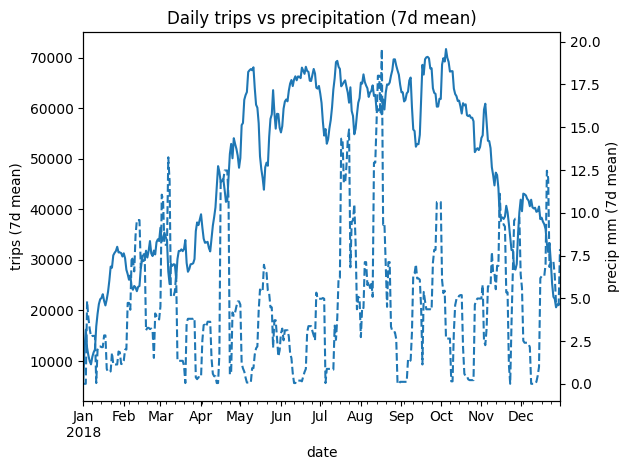

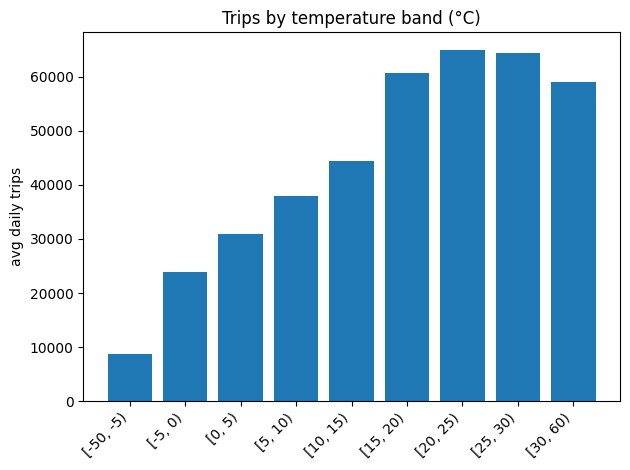

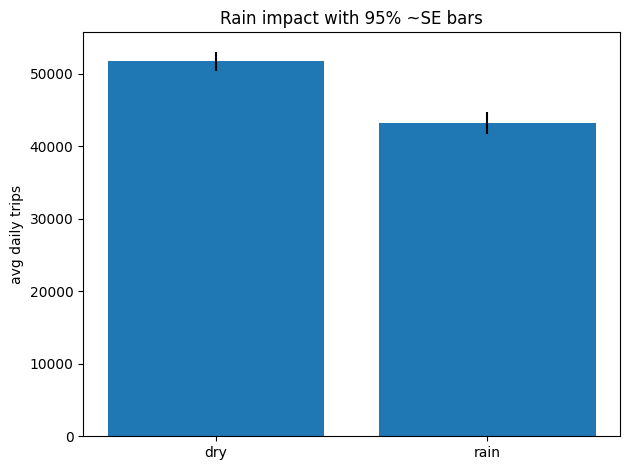

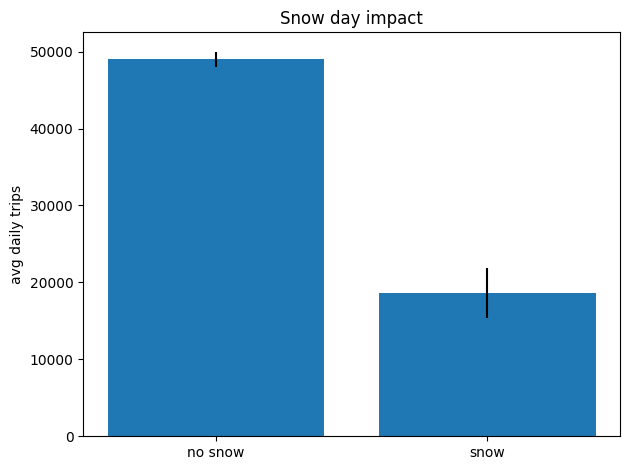

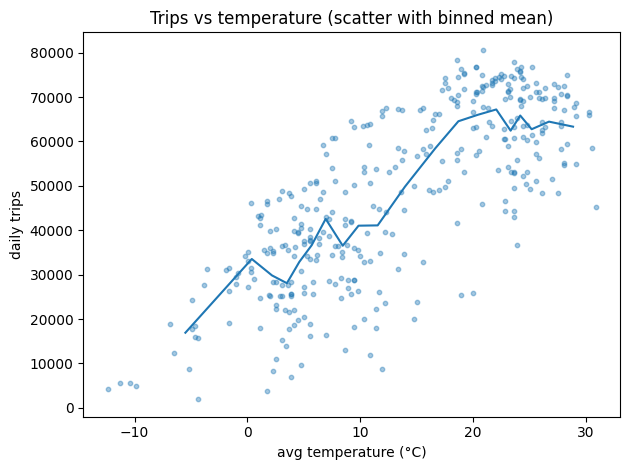

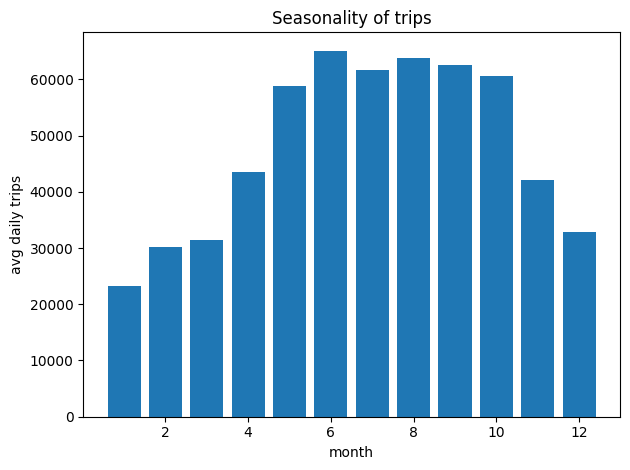

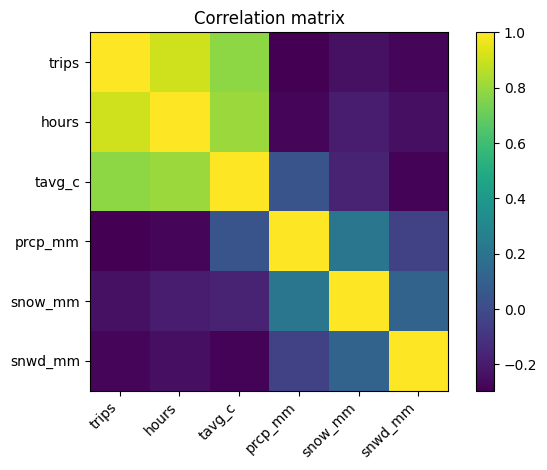

In [18]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

path_daily = "/Users/andreas/BusinessAnalytics1/business-analytics1-project/data/daily-summaries-2025-10-29T10-43-40.csv"

def pick(df, names):
    m = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return n
        if n.lower() in m: return m[n.lower()]
    return None

wx_raw = pd.read_csv(path_daily, dtype=str, low_memory=False)
date_col = pick(wx_raw, ["DATE","date","time"])
tmin_col = pick(wx_raw, ["TMIN"])
tmax_col = pick(wx_raw, ["TMAX"])
prcp_col = pick(wx_raw, ["PRCP"])
snow_col = pick(wx_raw, ["SNOW"])
snwd_col = pick(wx_raw, ["SNWD"])

wx = pd.DataFrame({"date": pd.to_datetime(wx_raw[date_col], errors="coerce").dt.normalize()})
wx["tmin_c"] = pd.to_numeric(wx_raw[tmin_col], errors="coerce")/10.0
wx["tmax_c"] = pd.to_numeric(wx_raw[tmax_col], errors="coerce")/10.0
wx["tavg_c"] = wx[["tmin_c","tmax_c"]].mean(axis=1)
wx["prcp_mm"] = pd.to_numeric(wx_raw[prcp_col], errors="coerce")/10.0
wx["snow_mm"] = pd.to_numeric(wx_raw[snow_col], errors="coerce")
wx["snwd_mm"] = pd.to_numeric(wx_raw[snwd_col], errors="coerce")
wx = wx.dropna(subset=["date"]).drop_duplicates("date").sort_values("date").reset_index(drop=True)

trip_daily = (df.assign(starttime=pd.to_datetime(df["starttime"], errors="coerce"),
                        tripduration=pd.to_numeric(df["tripduration"], errors="coerce"))
                .dropna(subset=["starttime"])
                .assign(date=lambda d: d["starttime"].dt.normalize())
                .groupby("date")
                .agg(trips=("starttime","size"), hours=("tripduration", lambda s: s.fillna(0).sum()/3600.0))
                .reset_index())

X = trip_daily.merge(wx, on="date", how="left")
X["rain"] = X["prcp_mm"].fillna(0) > 0
X["snow_day"] = X["snow_mm"].fillna(0) > 0
X["month"] = X["date"].dt.month
X = X.dropna(subset=["tavg_c","prcp_mm"])

plt.figure()
ts = X[["date","trips","prcp_mm"]].set_index("date").rolling(7, min_periods=1).mean()
ax = ts["trips"].plot()
ax2 = ax.twinx()
ts["prcp_mm"].plot(ax=ax2, linestyle="--")
ax.set_ylabel("trips (7d mean)")
ax2.set_ylabel("precip mm (7d mean)")
plt.title("Daily trips vs precipitation (7d mean)")
plt.tight_layout()
plt.show()

tb = pd.cut(X["tavg_c"], [-50,-5,0,5,10,15,20,25,30,60], right=False)
t_resp = X.groupby(tb)["trips"].mean().reset_index()
plt.figure()
plt.bar(t_resp["tavg_c"].astype(str), t_resp["trips"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("avg daily trips")
plt.title("Trips by temperature band (°C)")
plt.tight_layout()
plt.show()

grp = X.groupby("rain")["trips"].agg(mean="mean", std="std", n="size").reset_index()
err = (grp["std"]/np.sqrt(grp["n"])).values
plt.figure()
plt.bar(["dry","rain"], grp["mean"].values, yerr=err)
plt.ylabel("avg daily trips")
plt.title("Rain impact with 95% ~SE bars")
plt.tight_layout()
plt.show()

gs = X.groupby("snow_day")["trips"].agg(mean="mean", std="std", n="size").reset_index()
err2 = (gs["std"]/np.sqrt(gs["n"])).values
plt.figure()
plt.bar(["no snow","snow"], gs["mean"].values, yerr=err2)
plt.ylabel("avg daily trips")
plt.title("Snow day impact")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(X["tavg_c"], X["trips"], s=10, alpha=0.4)
q = pd.qcut(X["tavg_c"], 20, duplicates="drop")
line = X.groupby(q)["trips"].mean()
xc = X.groupby(q)["tavg_c"].mean()
plt.plot(xc.values, line.values)
plt.xlabel("avg temperature (°C)")
plt.ylabel("daily trips")
plt.title("Trips vs temperature (scatter with binned mean)")
plt.tight_layout()
plt.show()

m = X.groupby("month")[["trips","hours"]].mean().reset_index()
plt.figure()
plt.bar(m["month"].astype(int), m["trips"].values)
plt.xlabel("month")
plt.ylabel("avg daily trips")
plt.title("Seasonality of trips")
plt.tight_layout()
plt.show()

C = X[["trips","hours","tavg_c","prcp_mm","snow_mm","snwd_mm"]].corr().values
labels = ["trips","hours","tavg_c","prcp_mm","snow_mm","snwd_mm"]
plt.figure()
plt.imshow(C, aspect="equal", interpolation="nearest")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
plt.title("Correlation matrix")
plt.colorbar()
plt.tight_layout()
plt.show()


Next, I want to look at how to increase revenue and I want to do that by looking at the top earning bikes and look at their routes. Is it in the middle of town, is it outside of town, this can maybe say something about where we put too many bikes that are idle. We could also look at if long trips or short trips bring the most revenue and gain business insights.

In [3]:
tmp = df[['bikeid','tripduration']].copy()
tmp['tripduration'] = pd.to_numeric(tmp['tripduration'], errors='coerce')
top = (tmp.dropna()
         .groupby('bikeid', as_index=False)['tripduration'].sum()
         .sort_values('tripduration', ascending=False)
         .head(10))
top['rented_time'] = pd.to_timedelta(top['tripduration'], unit='s')
print(top[['bikeid','rented_time']].to_string(index=False))


 bikeid       rented_time
  30503 232 days 12:53:22
  30875 192 days 11:04:42
  16777 181 days 07:58:02
  16533 168 days 08:42:56
  18504 162 days 01:08:20
  30446 155 days 13:55:04
  33252 149 days 13:24:30
  19957 140 days 18:09:29
  15336 139 days 04:43:59
  31347 134 days 07:01:55


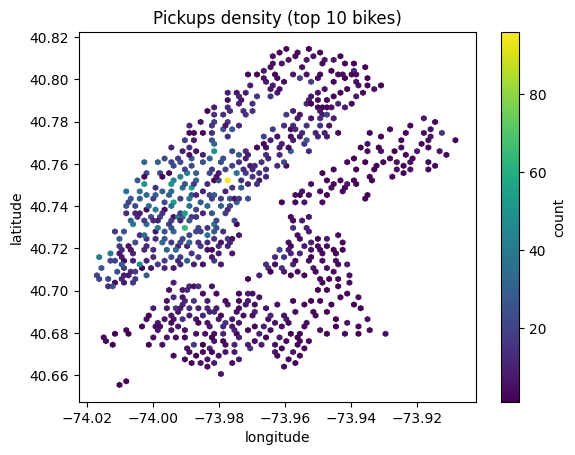

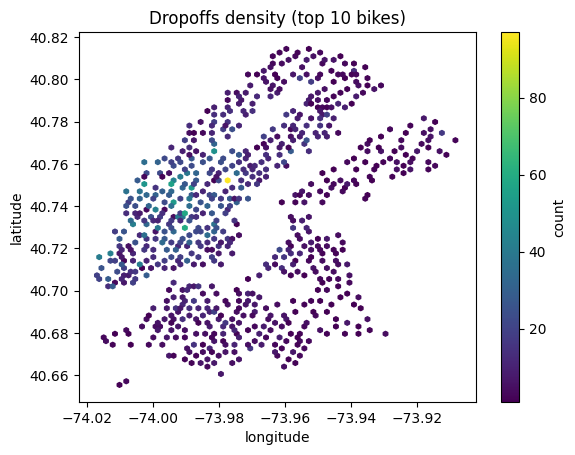

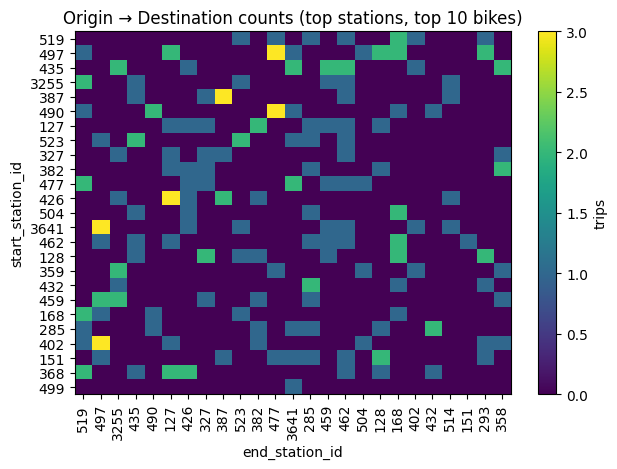

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

top_bikes = [30503, 30875, 16777, 16533, 18504, 30446, 33252, 19957, 15336, 31347]

sub = df[df['bikeid'].isin(top_bikes)].copy()

for col in ['start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude','start_station_id','end_station_id']:
    sub[col] = pd.to_numeric(sub[col], errors='coerce')

pick = sub.dropna(subset=['start_station_longitude','start_station_latitude'])
plt.figure()
plt.hexbin(pick['start_station_longitude'], pick['start_station_latitude'], gridsize=80, mincnt=1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Pickups density (top 10 bikes)')
plt.colorbar(label='count')
plt.show()

drop = sub.dropna(subset=['end_station_longitude','end_station_latitude'])
plt.figure()
plt.hexbin(drop['end_station_longitude'], drop['end_station_latitude'], gridsize=80, mincnt=1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Dropoffs density (top 10 bikes)')
plt.colorbar(label='count')
plt.show()

od = (sub.dropna(subset=['start_station_id','end_station_id'])
        .groupby(['start_station_id','end_station_id'])
        .size()
        .unstack(fill_value=0))

top_rows = od.sum(axis=1).nlargest(25).index
top_cols = od.sum(axis=0).nlargest(25).index
od_top = od.loc[top_rows, top_cols]

plt.figure()
plt.imshow(od_top.values, aspect='auto', interpolation='nearest')
plt.xticks(np.arange(od_top.shape[1]), od_top.columns.astype(int), rotation=90)
plt.yticks(np.arange(od_top.shape[0]), od_top.index.astype(int))
plt.title('Origin → Destination counts (top stations, top 10 bikes)')
plt.colorbar(label='trips')
plt.xlabel('end_station_id')
plt.ylabel('start_station_id')
plt.tight_layout()
plt.show()


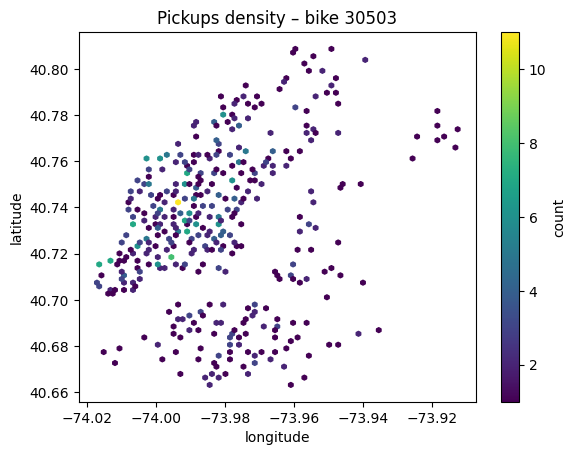

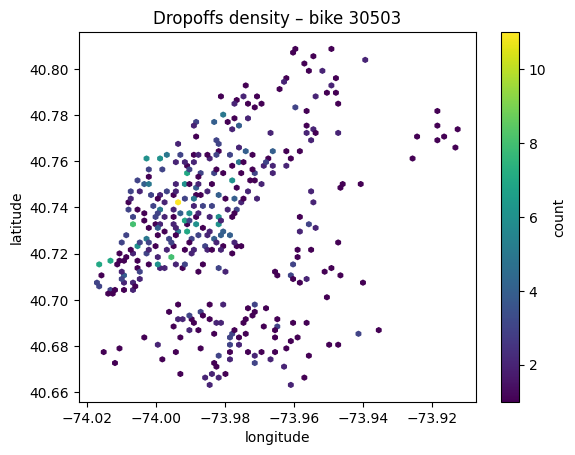

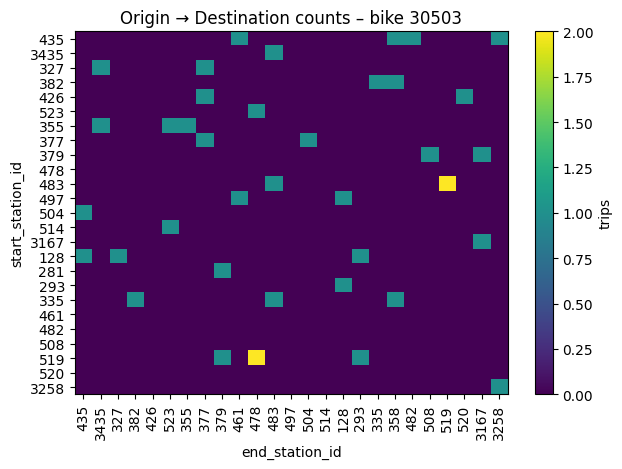

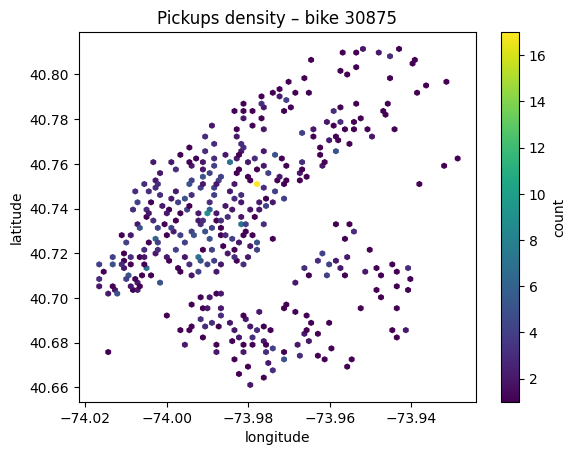

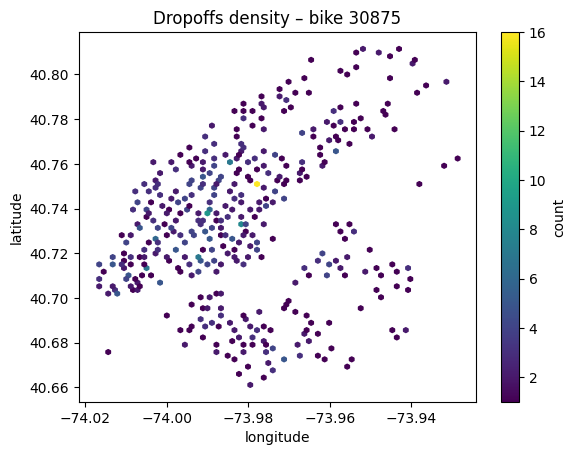

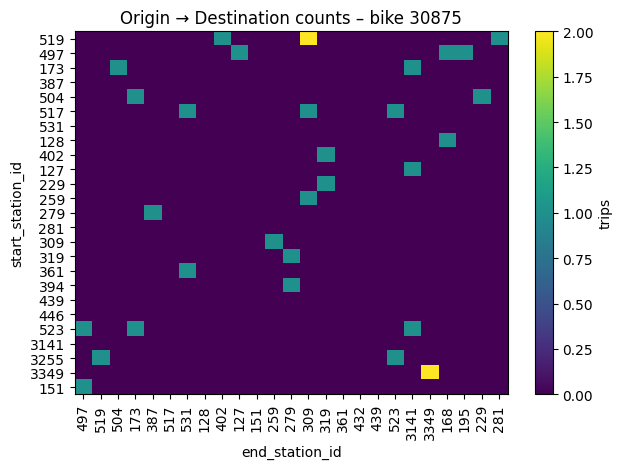

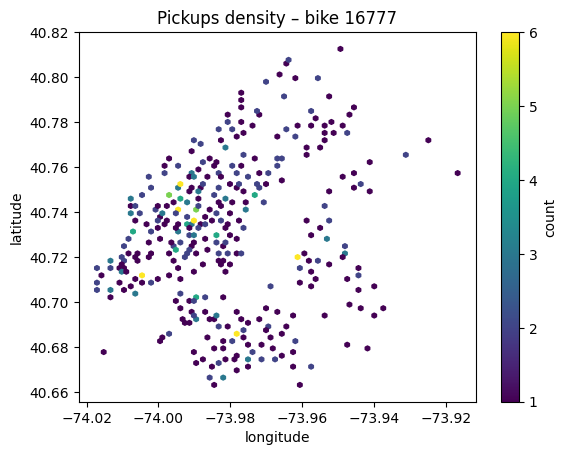

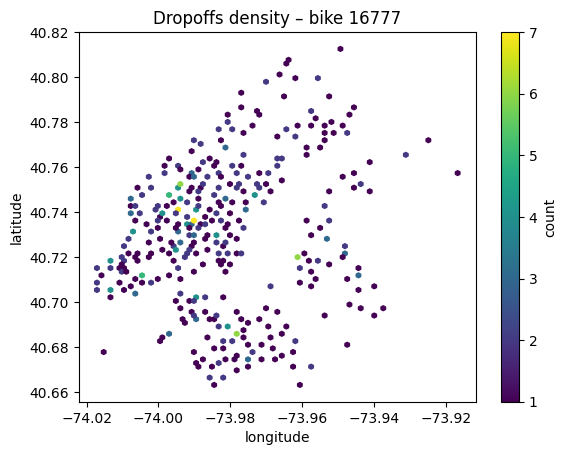

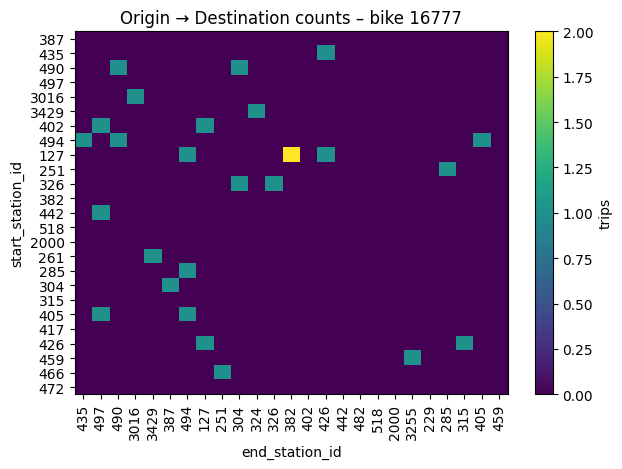

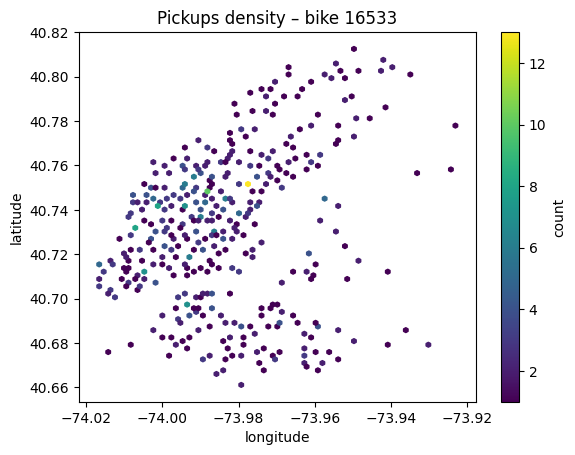

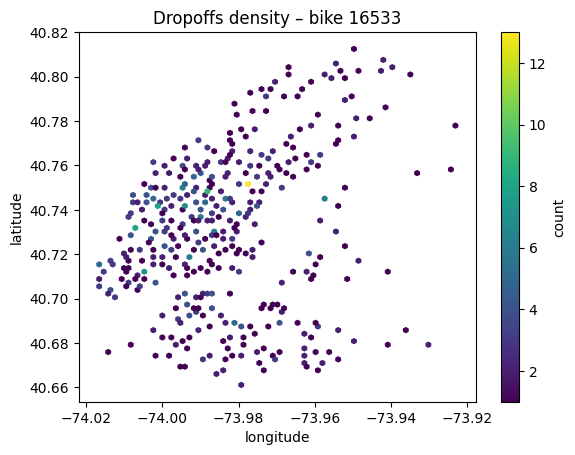

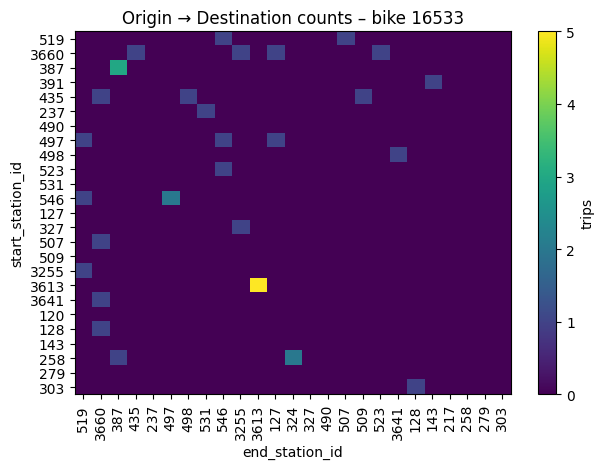

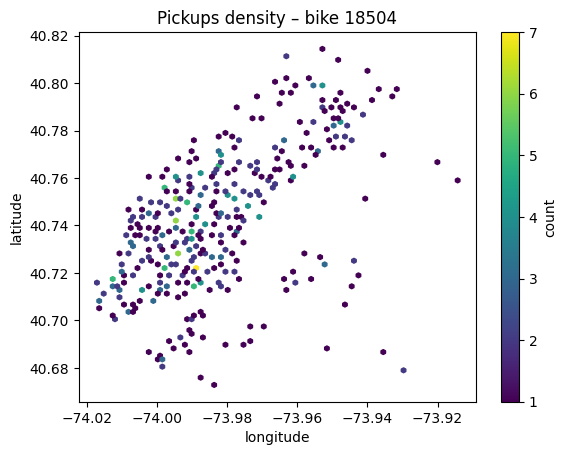

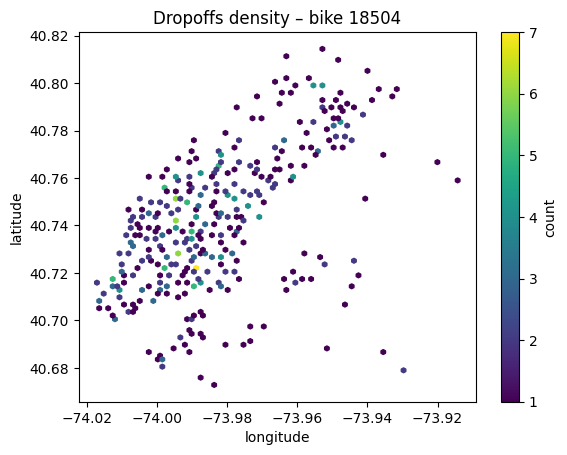

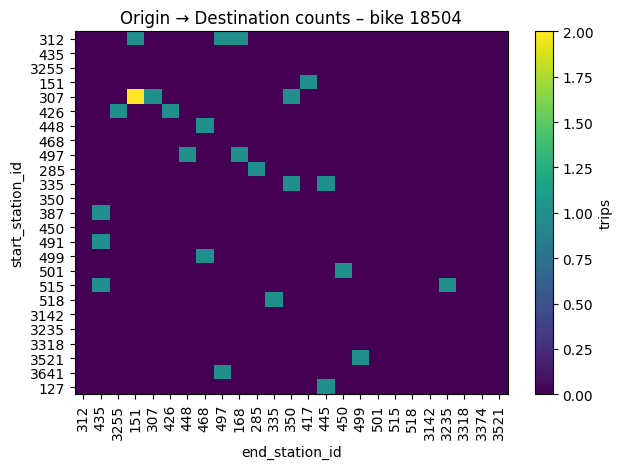

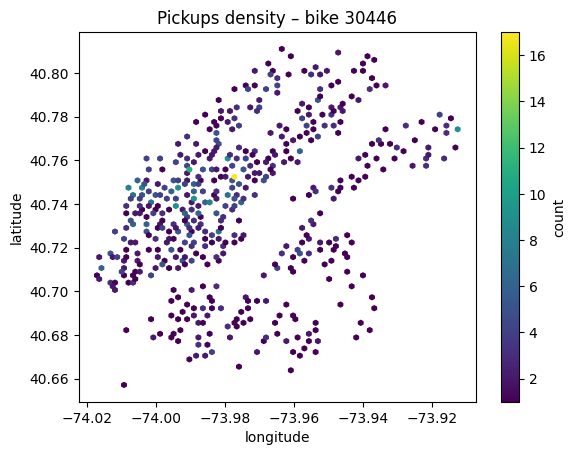

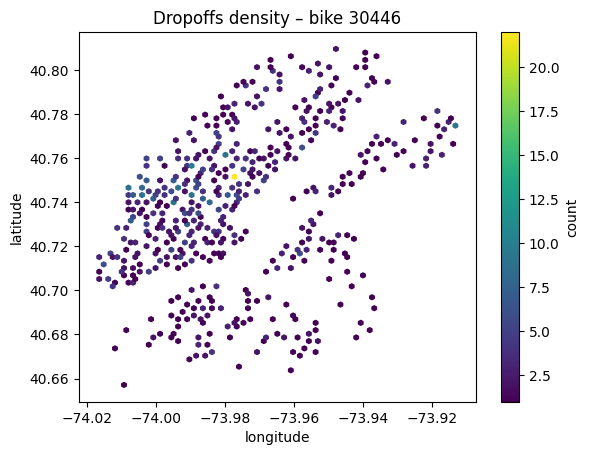

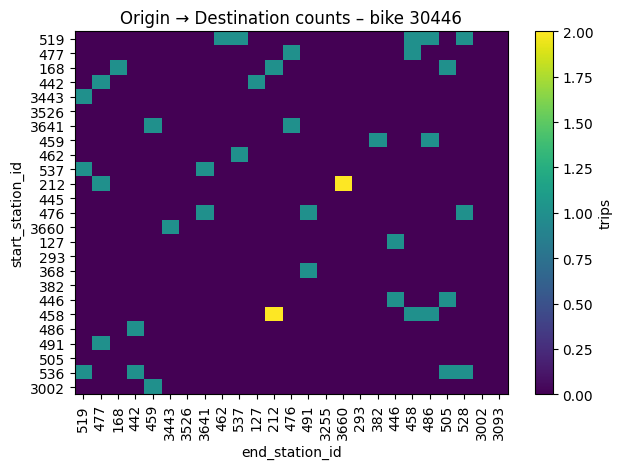

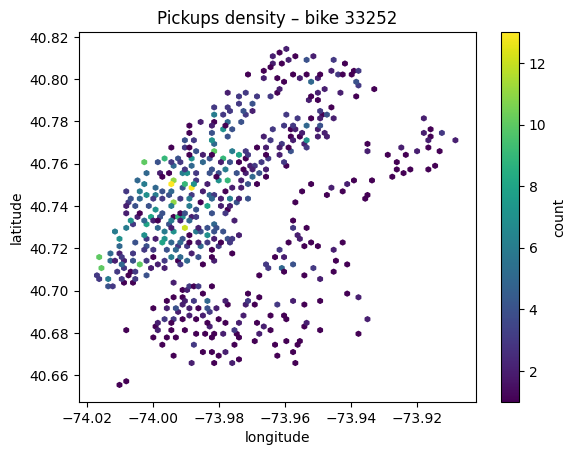

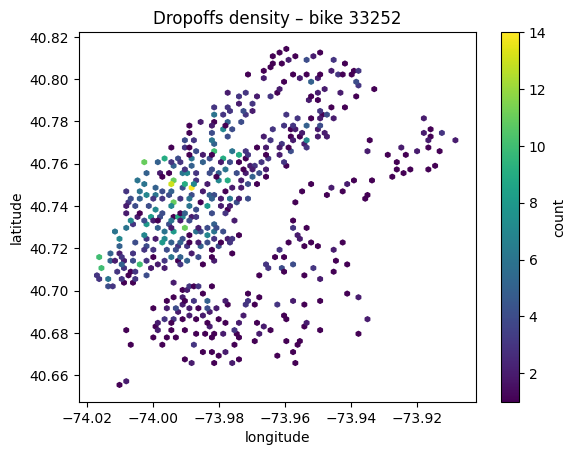

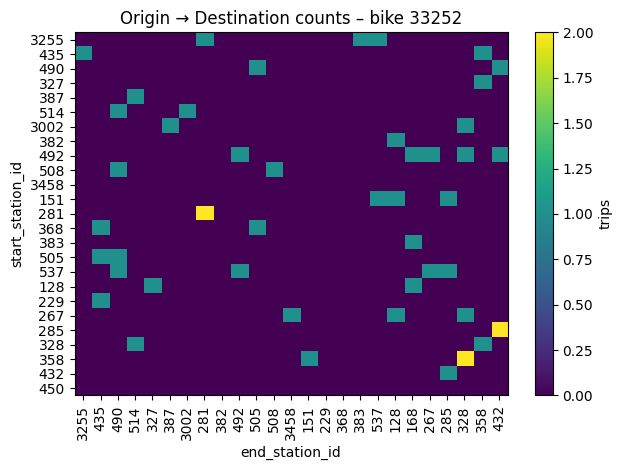

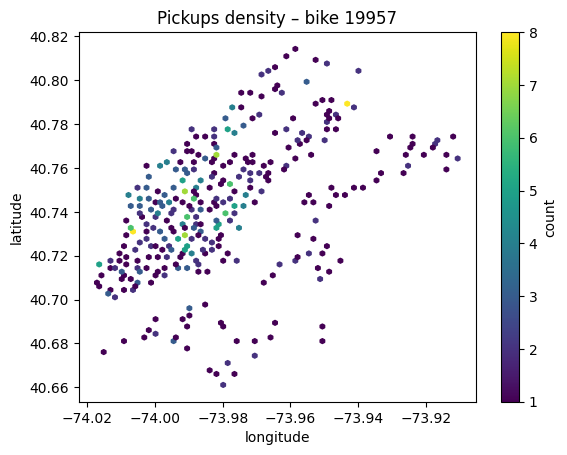

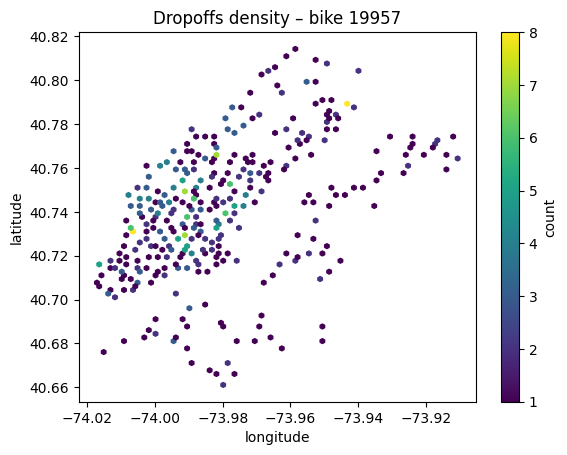

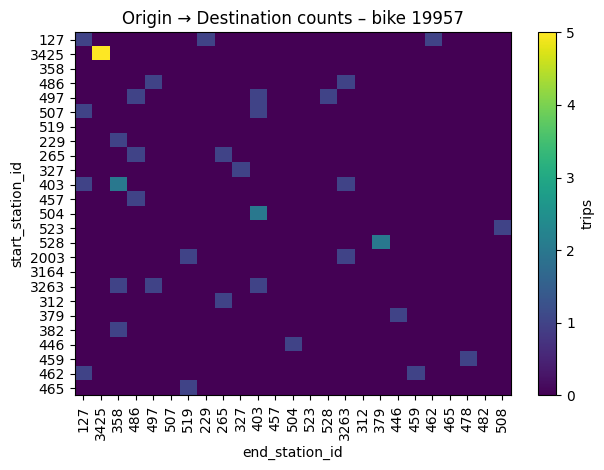

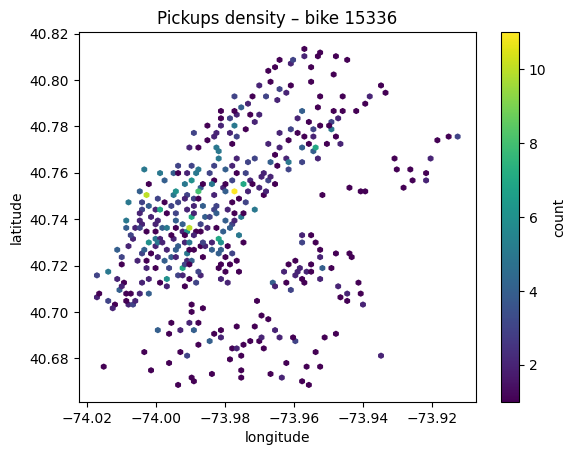

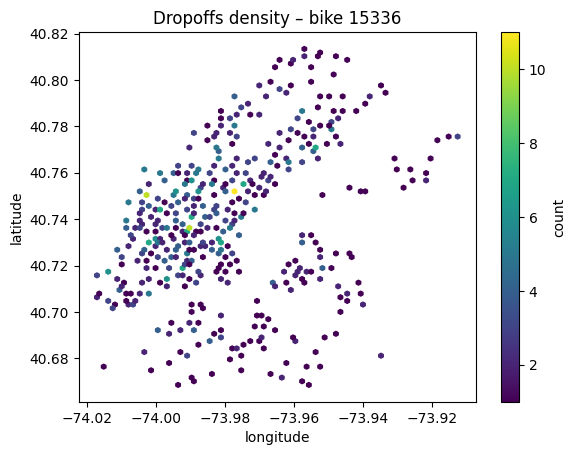

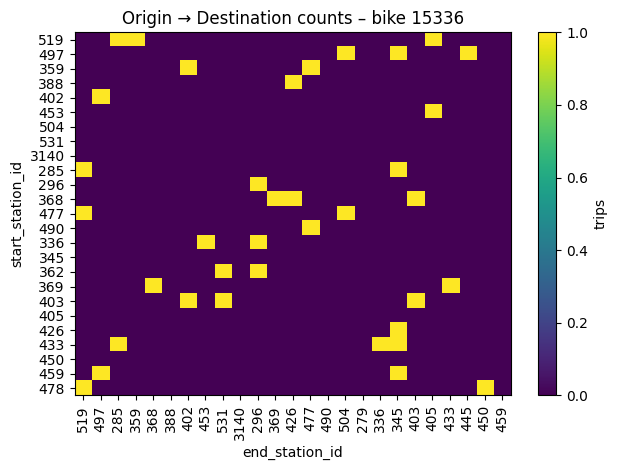

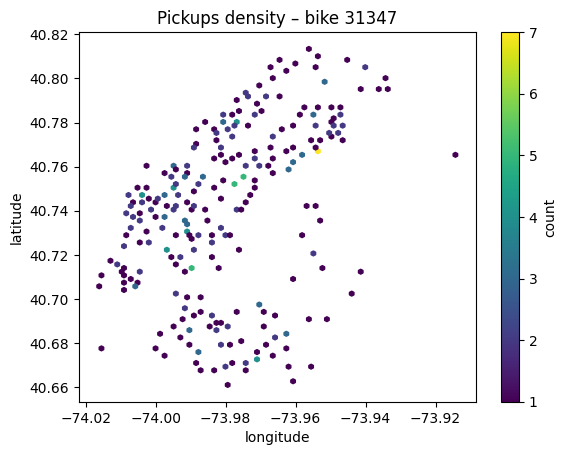

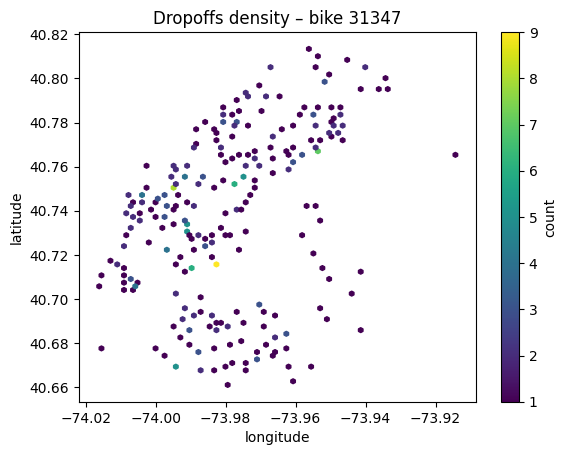

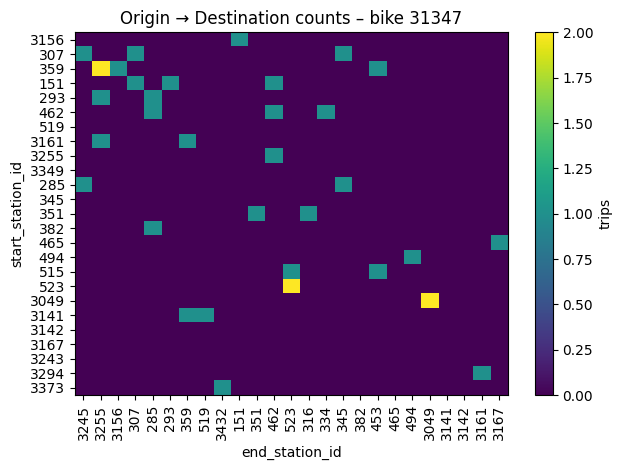

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

top_bikes = [30503, 30875, 16777, 16533, 18504, 30446, 33252, 19957, 15336, 31347]

sub_all = df[df['bikeid'].isin(top_bikes)].copy()
for col in ['start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude','start_station_id','end_station_id']:
    sub_all[col] = pd.to_numeric(sub_all[col], errors='coerce')

for b in top_bikes:
    sub = sub_all[sub_all['bikeid'] == b]

    pick = sub.dropna(subset=['start_station_longitude','start_station_latitude'])
    if len(pick):
        plt.figure()
        plt.hexbin(pick['start_station_longitude'], pick['start_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Pickups density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    drop = sub.dropna(subset=['end_station_longitude','end_station_latitude'])
    if len(drop):
        plt.figure()
        plt.hexbin(drop['end_station_longitude'], drop['end_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Dropoffs density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    od = (sub.dropna(subset=['start_station_id','end_station_id'])
            .groupby(['start_station_id','end_station_id'])
            .size()
            .unstack(fill_value=0))
    if not od.empty:
        r = od.sum(axis=1).nlargest(min(25, len(od))).index
        c = od.sum(axis=0).nlargest(min(25, od.shape[1])).index
        od_top = od.loc[r, c]
        plt.figure()
        plt.imshow(od_top.values, aspect='auto', interpolation='nearest')
        plt.xticks(np.arange(od_top.shape[1]), od_top.columns.astype(int), rotation=90)
        plt.yticks(np.arange(od_top.shape[0]), od_top.index.astype(int))
        plt.title(f'Origin → Destination counts – bike {b}')
        plt.colorbar(label='trips')
        plt.xlabel('end_station_id')
        plt.ylabel('start_station_id')
        plt.tight_layout()
        plt.show()


 bikeid     rented_time
  25870 0 days 00:01:26
  35626 0 days 00:01:38
  17667 0 days 00:02:14
  34867 0 days 00:03:46
  34924 0 days 00:03:48
  35533 0 days 00:04:40
  34598 0 days 00:05:40
  34561 0 days 00:05:43
  21940 0 days 00:05:45
  34834 0 days 00:05:51


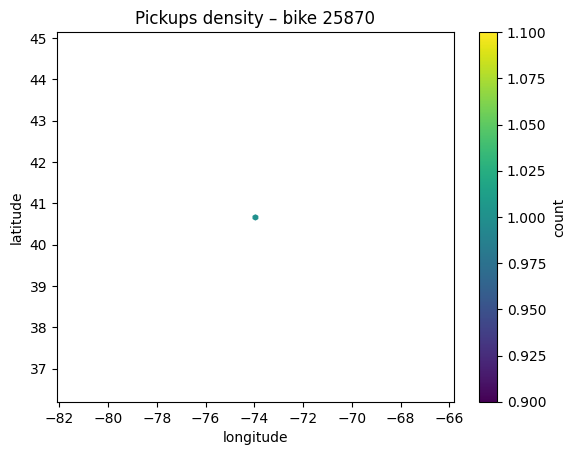

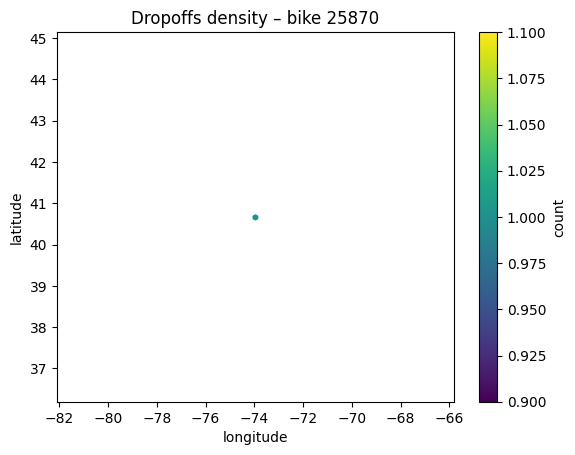

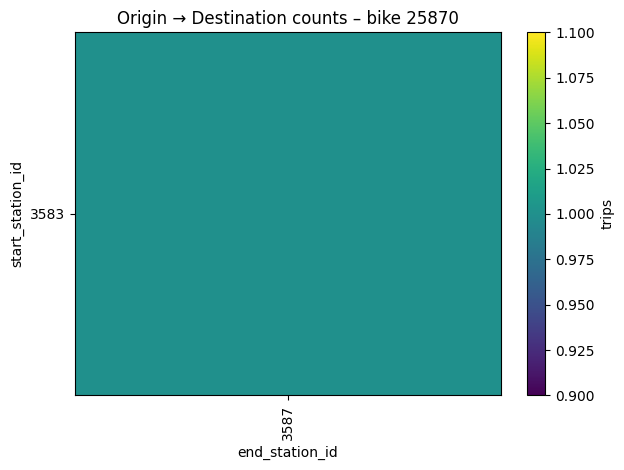

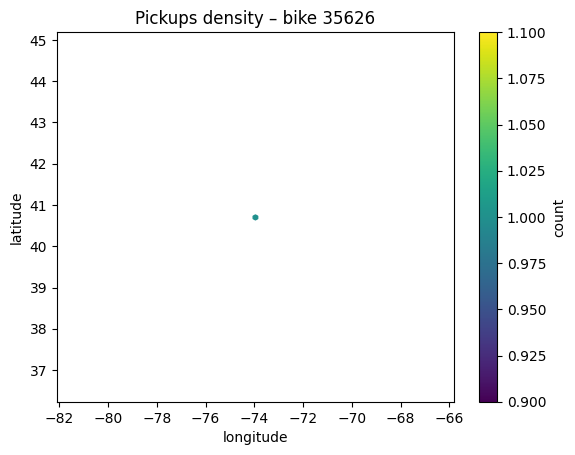

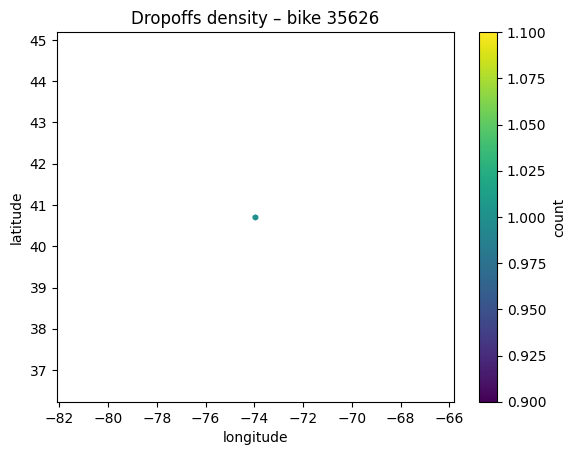

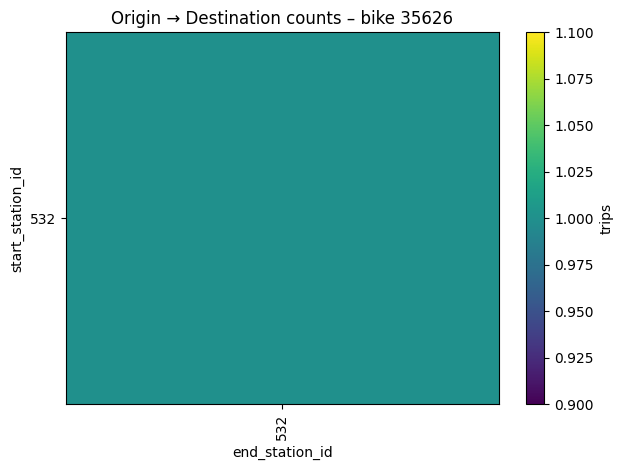

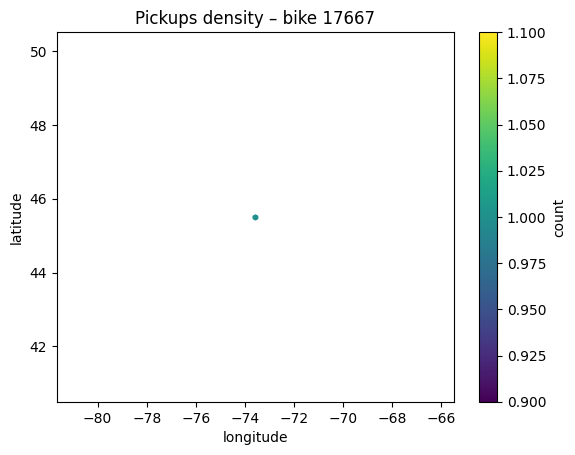

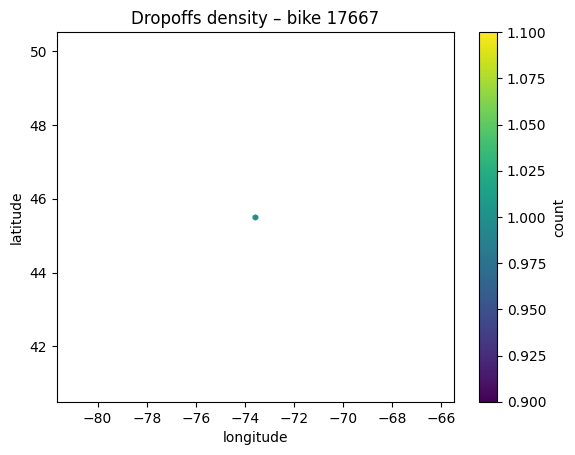

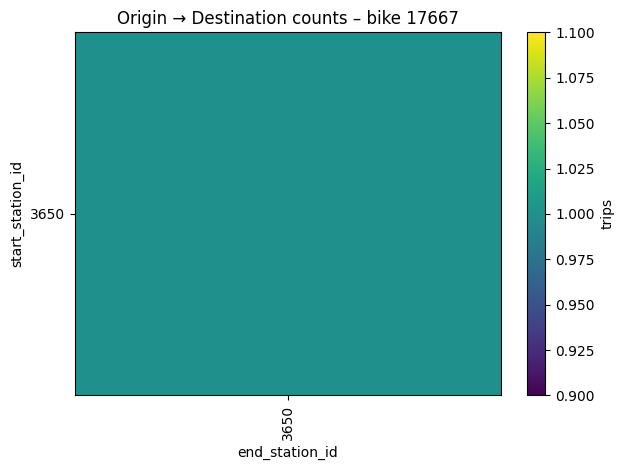

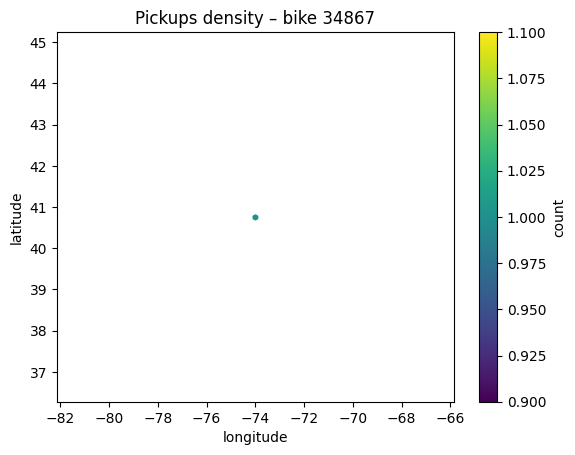

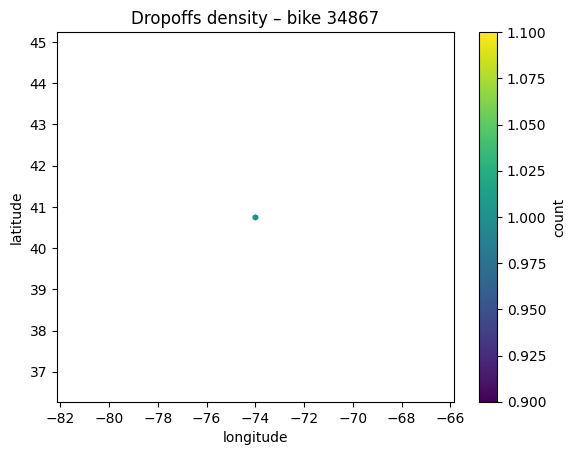

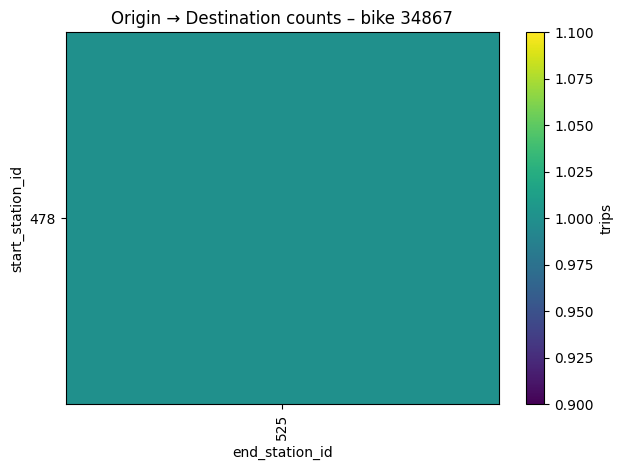

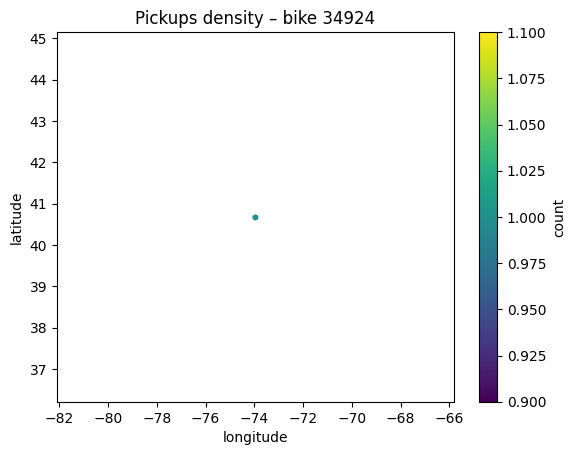

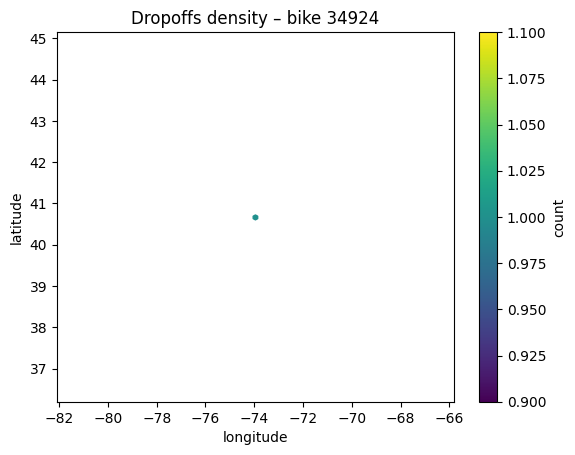

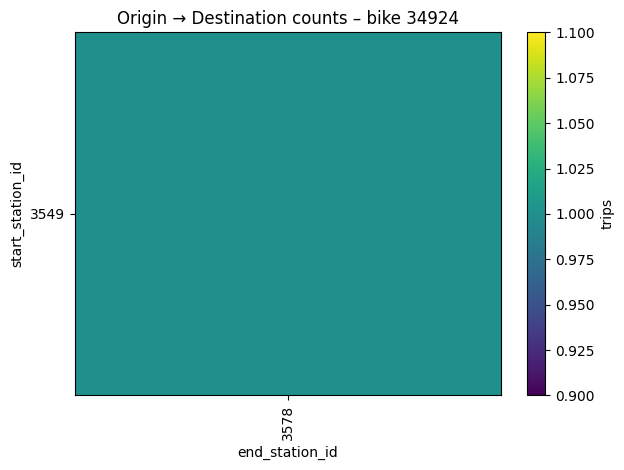

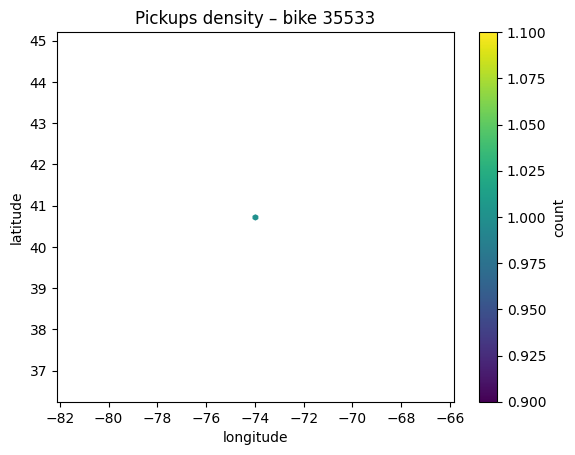

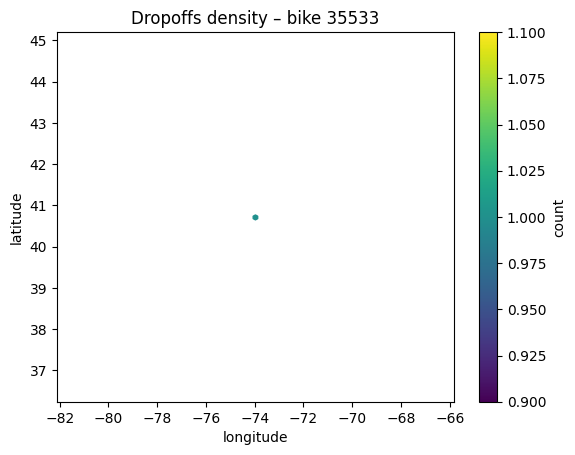

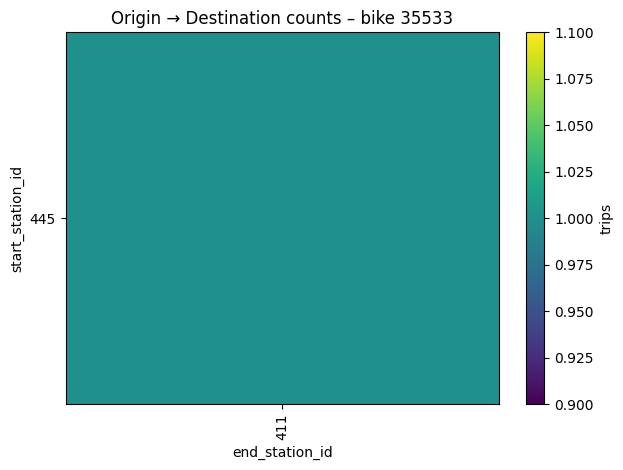

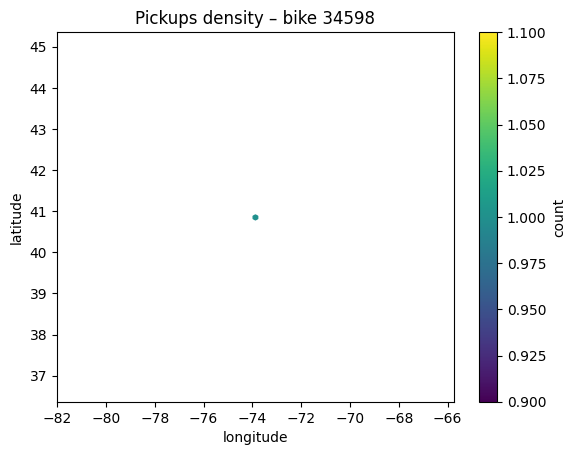

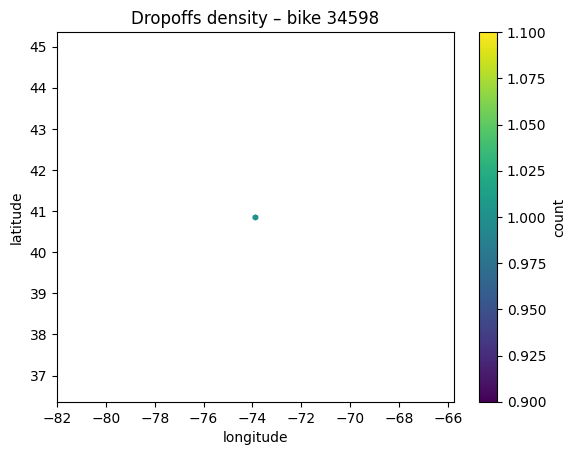

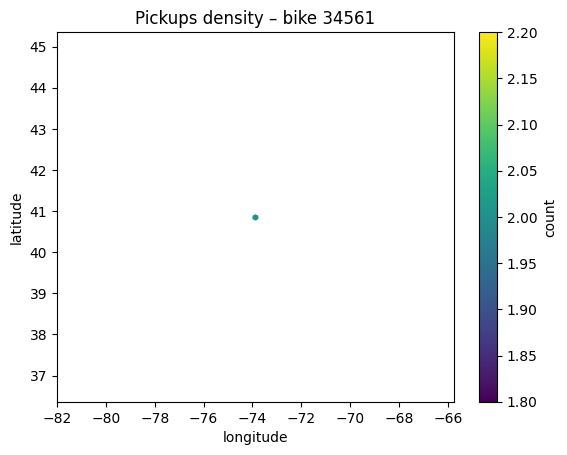

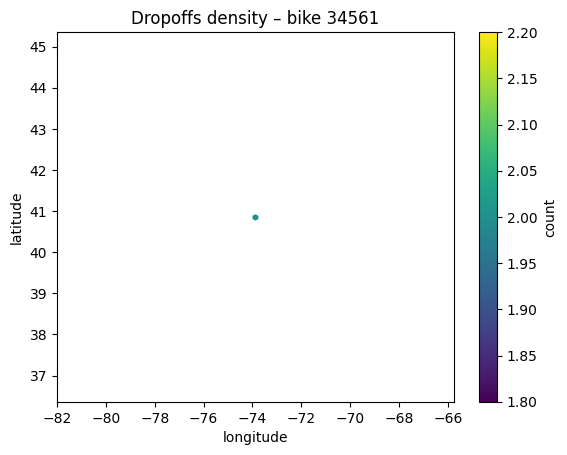

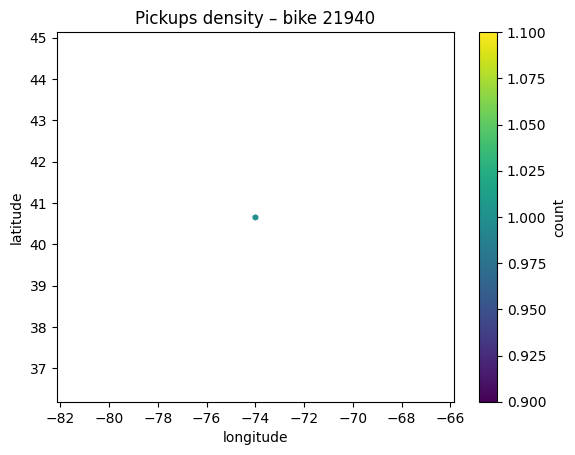

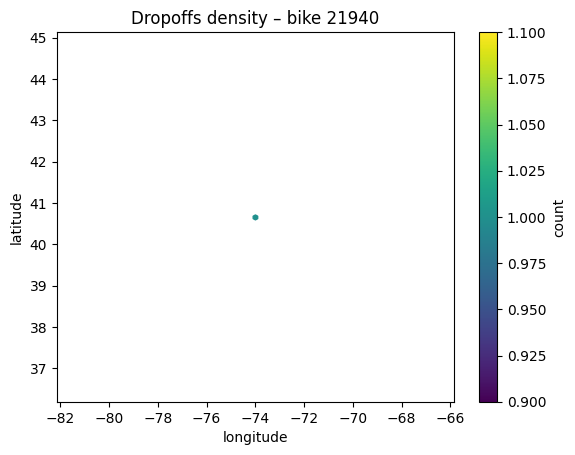

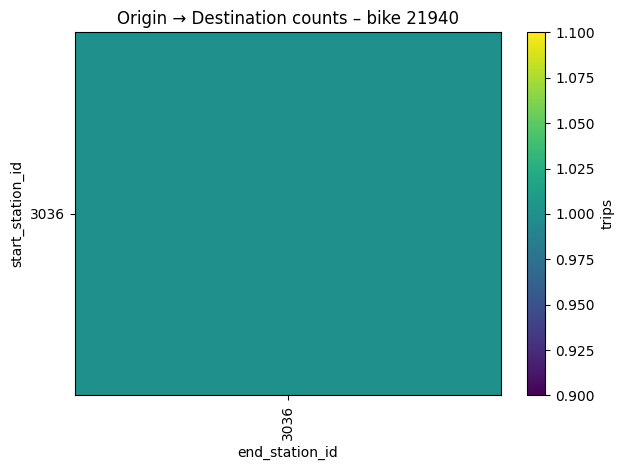

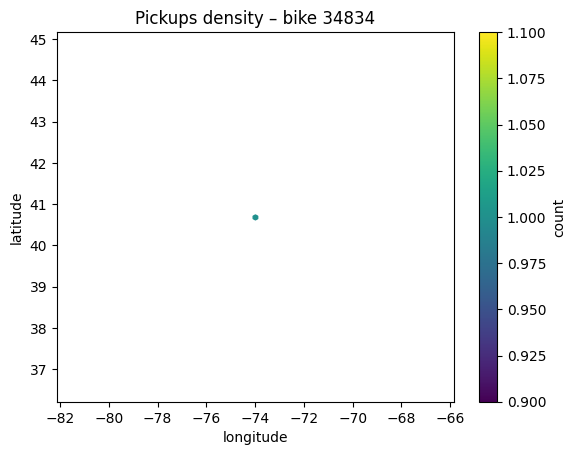

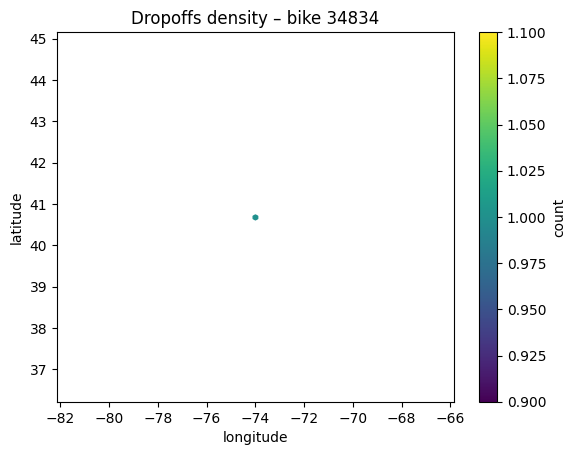

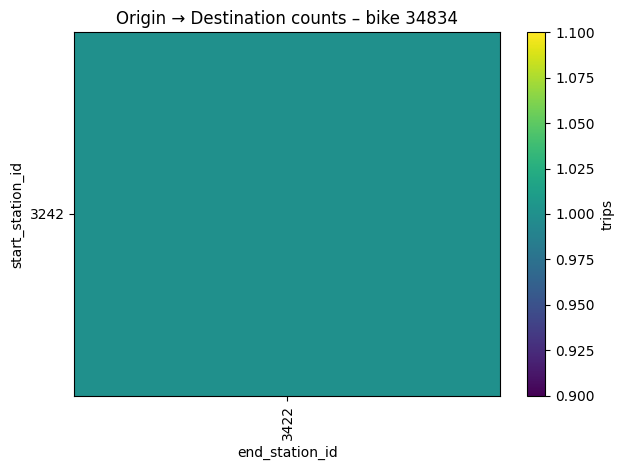

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tmp = df[['bikeid','tripduration']].copy()
tmp['tripduration'] = pd.to_numeric(tmp['tripduration'], errors='coerce')
bottom = (tmp.dropna()
            .groupby('bikeid', as_index=False)['tripduration'].sum()
            .sort_values('tripduration', ascending=True)
            .head(10))
bottom['rented_time'] = pd.to_timedelta(bottom['tripduration'], unit='s')
print(bottom[['bikeid','rented_time']].to_string(index=False))

bottom_bikes = bottom['bikeid'].tolist()
sub_all = df[df['bikeid'].isin(bottom_bikes)].copy()
for col in ['start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude','start_station_id','end_station_id']:
    sub_all[col] = pd.to_numeric(sub_all[col], errors='coerce')

for b in bottom_bikes:
    sub = sub_all[sub_all['bikeid'] == b]

    pick = sub.dropna(subset=['start_station_longitude','start_station_latitude'])
    if len(pick):
        plt.figure()
        plt.hexbin(pick['start_station_longitude'], pick['start_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Pickups density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    drop = sub.dropna(subset=['end_station_longitude','end_station_latitude'])
    if len(drop):
        plt.figure()
        plt.hexbin(drop['end_station_longitude'], drop['end_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Dropoffs density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    od = (sub.dropna(subset=['start_station_id','end_station_id'])
            .groupby(['start_station_id','end_station_id'])
            .size()
            .unstack(fill_value=0))
    if not od.empty:
        r = od.sum(axis=1).nlargest(min(25, len(od))).index
        c = od.sum(axis=0).nlargest(min(25, od.shape[1])).index
        od_top = od.loc[r, c]
        plt.figure()
        plt.imshow(od_top.values, aspect='auto', interpolation='nearest')
        plt.xticks(np.arange(od_top.shape[1]), od_top.columns.astype(int), rotation=90)
        plt.yticks(np.arange(od_top.shape[0]), od_top.index.astype(int))
        plt.title(f'Origin → Destination counts – bike {b}')
        plt.colorbar(label='trips')
        plt.xlabel('end_station_id')
        plt.ylabel('start_station_id')
        plt.tight_layout()
        plt.show()


/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_45859/258660132.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat = sub.groupby('bikeid').apply(bike_metrics).reset_index(drop=True)


trips         total_hours              median_trip_min           peak_share           \
         mean median         mean       median            mean    median       mean   median   
group                                                                                          
bottom    1.1    1.0     0.067528     0.070556        3.765833  3.783333   0.400000  0.00000   
top     782.9  748.0  3974.703861  3811.528333       10.196667  9.900000   0.427281  0.43411   

       start_station_demand_mean               idle_median_min            reposition_share            \
                            mean        median            mean     median             mean    median   
group                                                                                                  
bottom              18851.200000   9093.000000        0.871333   0.871333         0.000000  0.000000   
top                 41048.734796  41833.837638       55.913521  52.803379         0.046779  0.035615   

       reposition_dist_km           mean_od_km           pickup_spread_km           pct_roundtrips            \
                     mean    median       mean    median             mean    median           mean    median   
group                                                                                                          
bottom           0.000000  0.000000   0.373621  0.383367         0.000000  0.000000        0.50000  0.500000   
top              0.178447  0.119015   1.736588  1.753041         3.205316  3.168886        0.02012  0.016656   

       active_span_days        unique_start_stations        unique_end_stations         
                   mean median                  mean median                mean median  
group                                                                                   
bottom              0.0    0.0                   1.0    1.0                 1.0    1.0  
top               352.0  358.5                 371.8  366.5               370.3  368.0

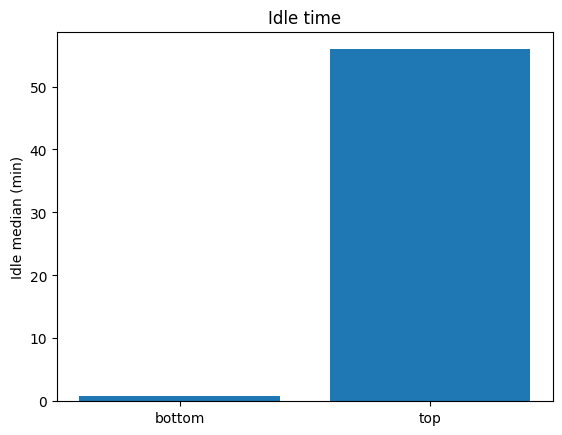

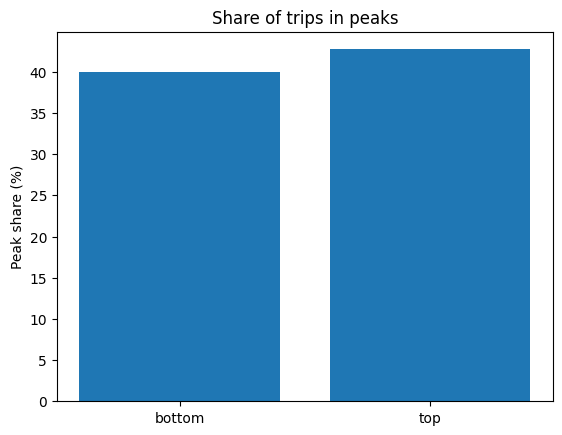

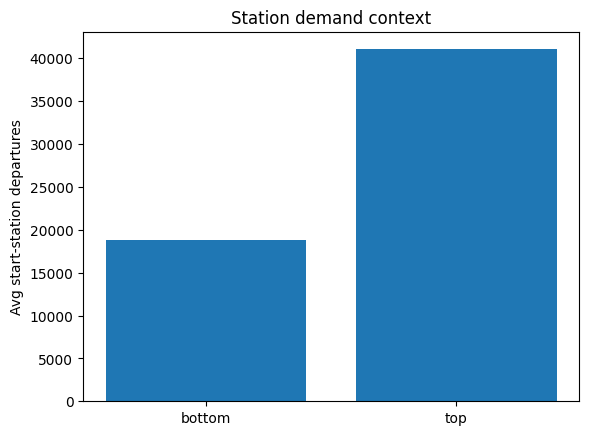

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

d = df[['bikeid','tripduration']].copy()
d['tripduration'] = pd.to_numeric(d['tripduration'], errors='coerce')
tot = d.dropna().groupby('bikeid', as_index=False)['tripduration'].sum()
top_ids = tot.nlargest(10, 'tripduration')['bikeid'].tolist()
bottom_ids = tot.nsmallest(10, 'tripduration')['bikeid'].tolist()
ids = top_ids + bottom_ids

cols_num = ['tripduration','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']
sub = df[df['bikeid'].isin(ids)].copy()
for c in cols_num:
    if c in sub.columns:
        sub[c] = pd.to_numeric(sub[c], errors='coerce')
sub['starttime'] = pd.to_datetime(sub['starttime'], errors='coerce')
sub['stoptime'] = pd.to_datetime(sub['stoptime'], errors='coerce')
sub['start_station_id'] = sub['start_station_id'].astype(str)
sub['end_station_id'] = sub['end_station_id'].astype(str)

station_out = df['start_station_id'].astype(str).value_counts()
sub['start_station_out'] = sub['start_station_id'].map(station_out)

def bike_metrics(g):
    g = g.sort_values('starttime')
    n_trips = len(g)
    total_sec = g['tripduration'].sum()
    mean_sec = g['tripduration'].mean()
    median_sec = g['tripduration'].median()
    unique_start = g['start_station_id'].nunique(dropna=True)
    unique_end = g['end_station_id'].nunique(dropna=True)
    same_id = g[['start_station_id','end_station_id']].dropna()
    pct_round = (same_id['start_station_id'] == same_id['end_station_id']).mean() if len(same_id) else np.nan
    od_known = g.dropna(subset=['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude'])
    mean_od_km = float(haversine(od_known['start_station_latitude'].values,
                                 od_known['start_station_longitude'].values,
                                 od_known['end_station_latitude'].values,
                                 od_known['end_station_longitude'].values).mean()) if len(od_known) else np.nan
    pick = g.dropna(subset=['start_station_latitude','start_station_longitude'])
    if len(pick):
        lat0 = pick['start_station_latitude'].mean()
        lon0 = pick['start_station_longitude'].mean()
        spread_km = float(haversine(pick['start_station_latitude'].values,
                                    pick['start_station_longitude'].values,
                                    np.full(len(pick), lat0),
                                    np.full(len(pick), lon0)).mean())
    else:
        spread_km = np.nan
    st = g['starttime'].dropna()
    if len(st):
        dow = st.dt.dayofweek
        hr = st.dt.hour
        peak_share = ((dow <= 4) & (hr.isin([7,8,9,16,17,18,19]))).mean()
        weekend_share = (dow >= 5).mean()
        late_share = (hr.isin([22,23,0,1,2,3,4,5])).mean()
    else:
        peak_share = np.nan; weekend_share = np.nan; late_share = np.nan
    g['prev_stoptime'] = g['stoptime'].shift(1)
    g['prev_end_station_id'] = g['end_station_id'].shift(1)
    g['prev_end_lat'] = g['end_station_latitude'].shift(1)
    g['prev_end_lon'] = g['end_station_longitude'].shift(1)
    pairs = g.dropna(subset=['starttime','prev_stoptime'])
    idle_min = (pairs['starttime'] - pairs['prev_stoptime']).dt.total_seconds()/60.0
    idle_median_min = float(idle_min.median()) if len(idle_min) else np.nan
    idle_mean_min = float(idle_min.mean()) if len(idle_min) else np.nan
    rep = pairs.dropna(subset=['prev_end_station_id','start_station_id'])
    reposition_share = (rep['start_station_id'] != rep['prev_end_station_id']).mean() if len(rep) else np.nan
    rep_geo = pairs.dropna(subset=['prev_end_lat','prev_end_lon','start_station_latitude','start_station_longitude'])
    reposition_dist_km = float(haversine(rep_geo['prev_end_lat'].values,
                                         rep_geo['prev_end_lon'].values,
                                         rep_geo['start_station_latitude'].values,
                                         rep_geo['start_station_longitude'].values).mean()) if len(rep_geo) else np.nan
    station_demand_mean = float(g['start_station_out'].dropna().mean()) if 'start_station_out' in g else np.nan
    active_span_days = (g['stoptime'].max() - g['starttime'].min()).days if g['starttime'].notna().any() and g['stoptime'].notna().any() else np.nan
    return pd.Series({
        'bikeid': g['bikeid'].iloc[0],
        'trips': n_trips,
        'total_hours': total_sec/3600.0,
        'mean_trip_min': mean_sec/60.0 if pd.notna(mean_sec) else np.nan,
        'median_trip_min': median_sec/60.0 if pd.notna(median_sec) else np.nan,
        'unique_start_stations': unique_start,
        'unique_end_stations': unique_end,
        'pct_roundtrips': pct_round,
        'mean_od_km': mean_od_km,
        'pickup_spread_km': spread_km,
        'peak_share': peak_share,
        'weekend_share': weekend_share,
        'late_night_share': late_share,
        'idle_median_min': idle_median_min,
        'idle_mean_min': idle_mean_min,
        'reposition_share': reposition_share,
        'reposition_dist_km': reposition_dist_km,
        'start_station_demand_mean': station_demand_mean,
        'active_span_days': active_span_days
    })

feat = sub.groupby('bikeid').apply(bike_metrics).reset_index(drop=True)
feat['group'] = np.where(feat['bikeid'].isin(top_ids), 'top','bottom')
cols_show = ['trips','total_hours','median_trip_min','peak_share','start_station_demand_mean','idle_median_min','reposition_share','reposition_dist_km','mean_od_km','pickup_spread_km','pct_roundtrips','active_span_days','unique_start_stations','unique_end_stations']
summary = feat.groupby('group')[cols_show].agg(['mean','median'])
display(summary)

gbar = feat.groupby('group')[['idle_median_min','peak_share','start_station_demand_mean','reposition_dist_km','mean_od_km']].mean().reset_index()

plt.figure()
plt.bar(gbar['group'], gbar['idle_median_min'])
plt.ylabel('Idle median (min)')
plt.title('Idle time')
plt.show()

plt.figure()
plt.bar(gbar['group'], gbar['peak_share']*100.0)
plt.ylabel('Peak share (%)')
plt.title('Share of trips in peaks')
plt.show()

plt.figure()
plt.bar(gbar['group'], gbar['start_station_demand_mean'])
plt.ylabel('Avg start-station departures')
plt.title('Station demand context')
plt.show()


 bikeid  trips     rented_time
  34896      5 0 days 00:18:06
  21341      5 0 days 00:23:37
  34508      6 0 days 00:38:28
  34889      5 0 days 00:38:50
  34549      5 0 days 00:40:16
  28334      5 0 days 00:42:58
  26123      5 0 days 00:47:17
  34530      7 0 days 00:48:49
  28984      6 0 days 00:52:56
  25702      6 0 days 00:53:35


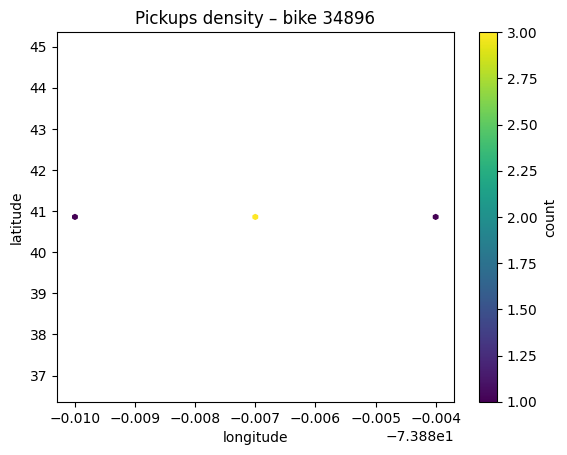

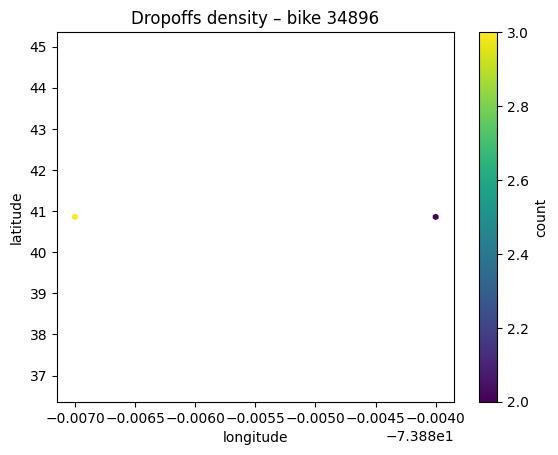

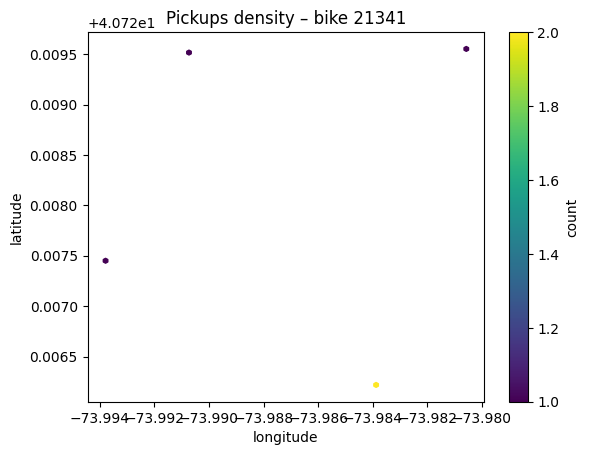

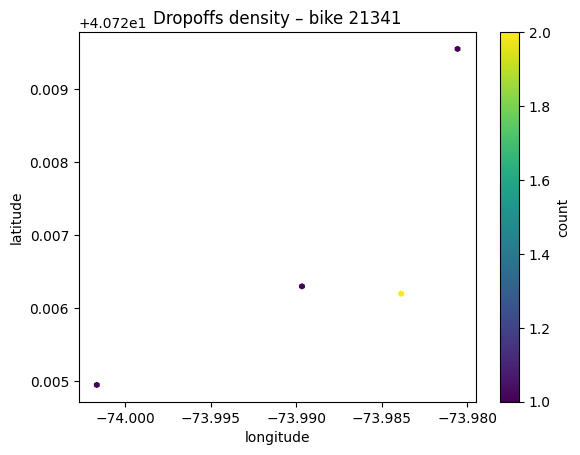

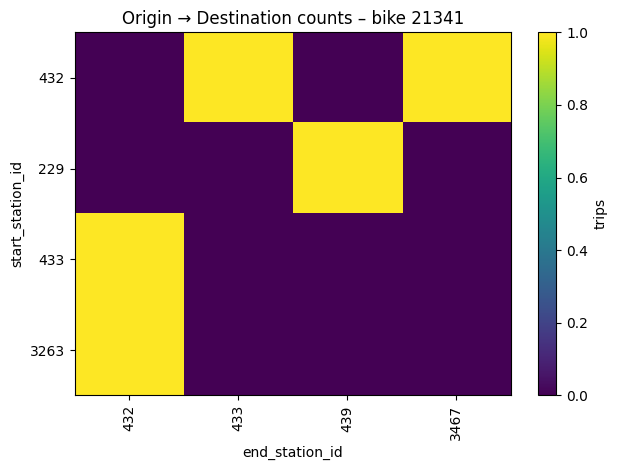

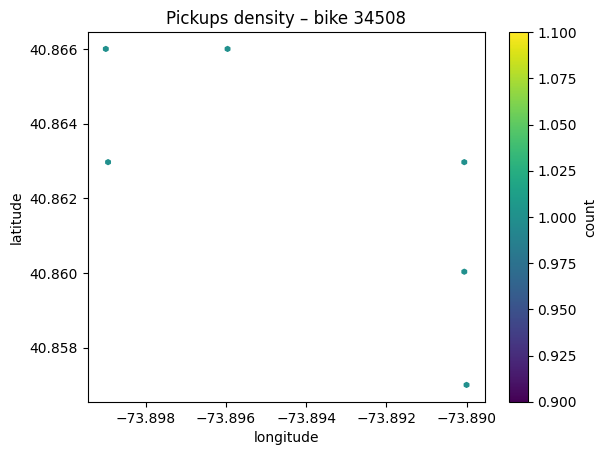

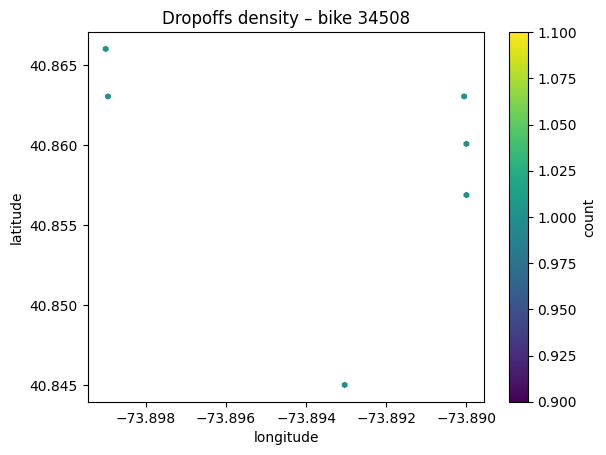

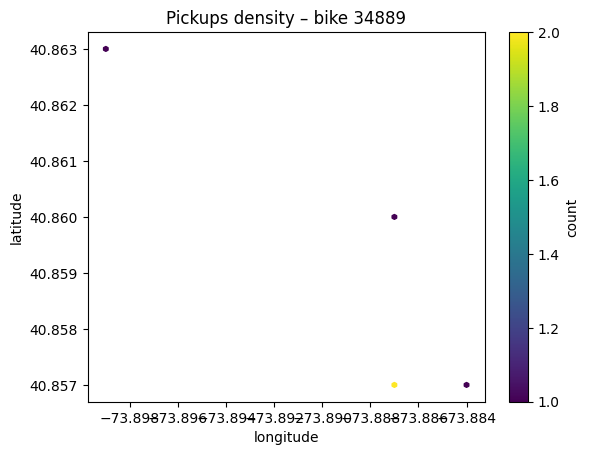

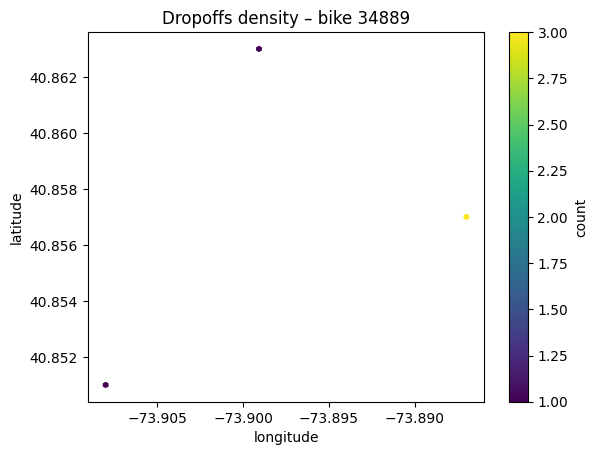

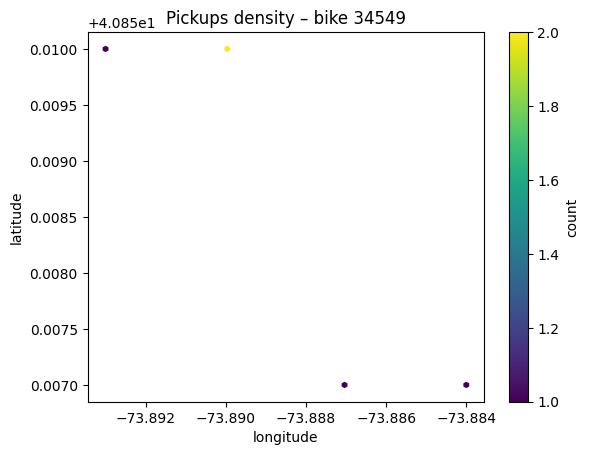

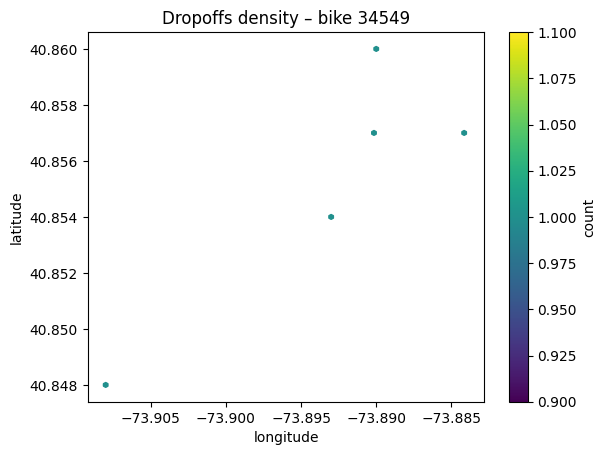

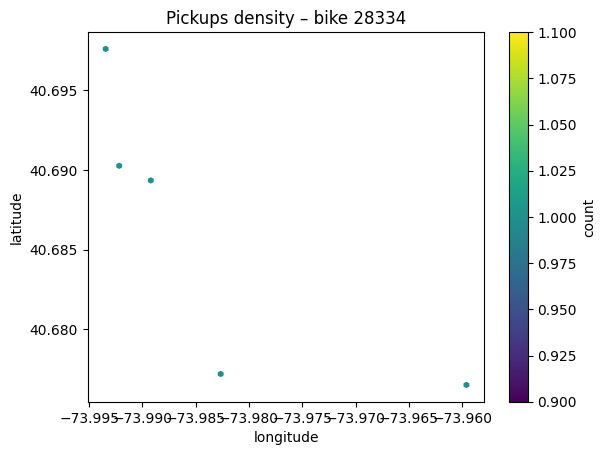

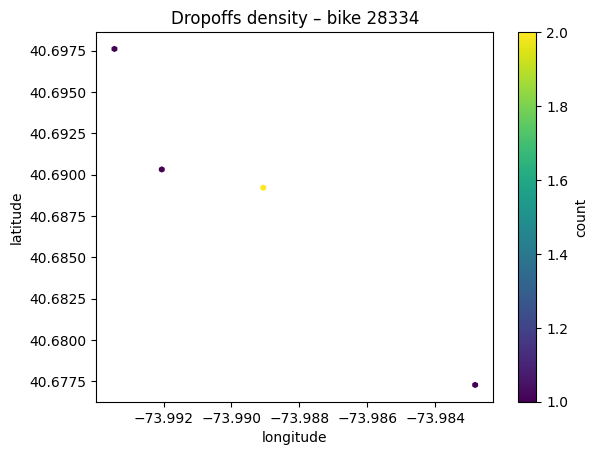

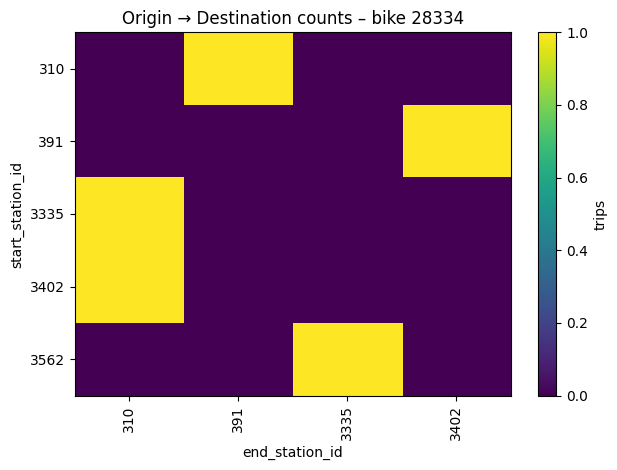

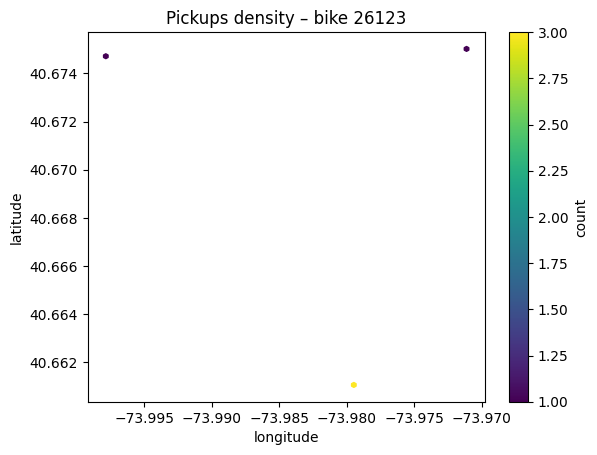

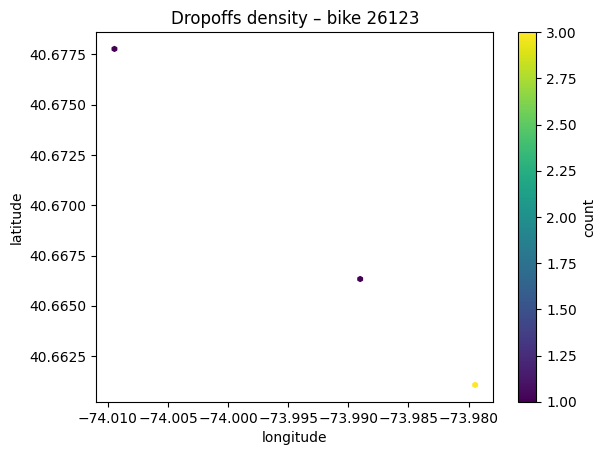

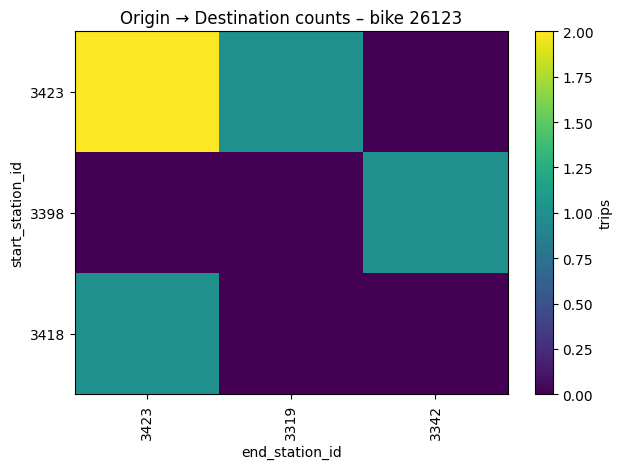

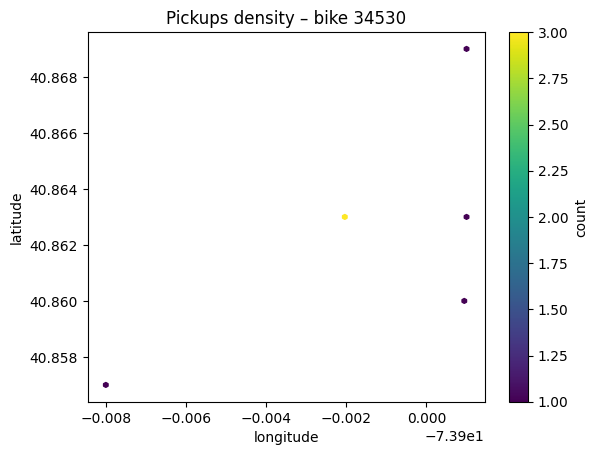

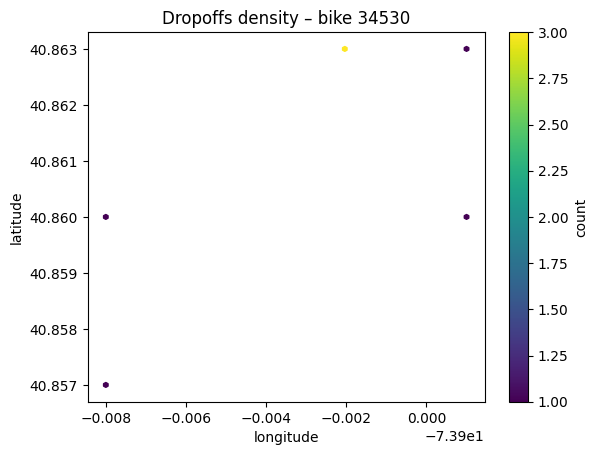

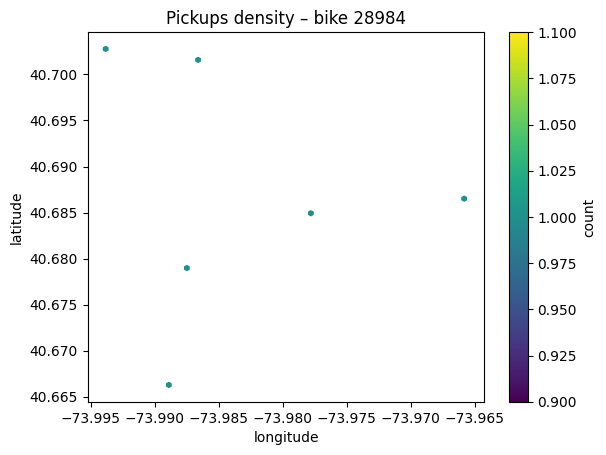

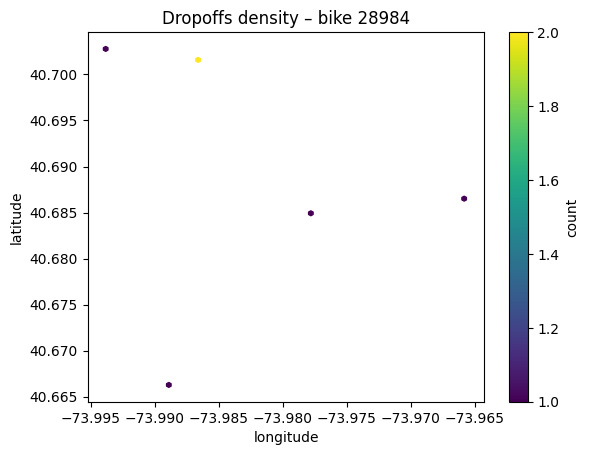

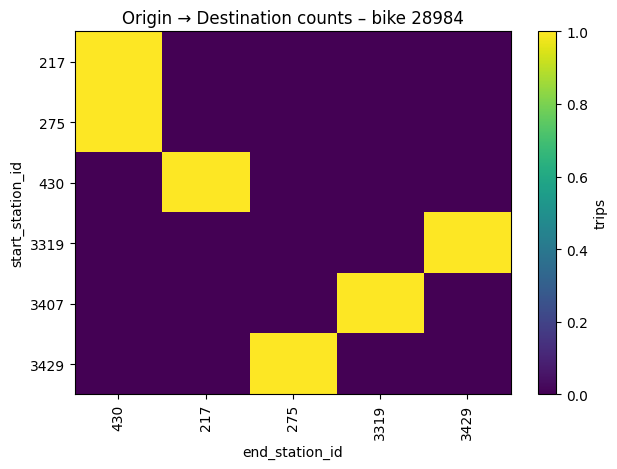

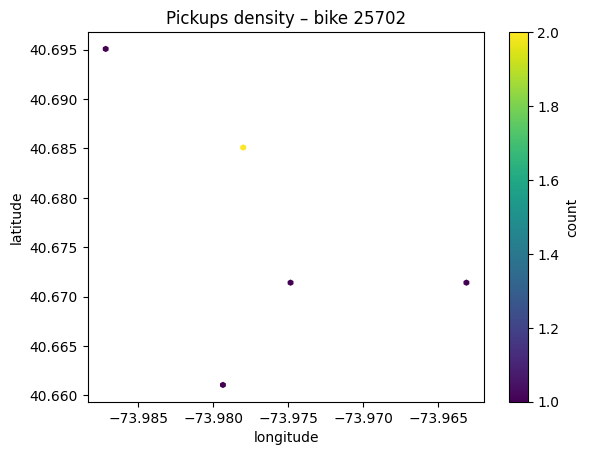

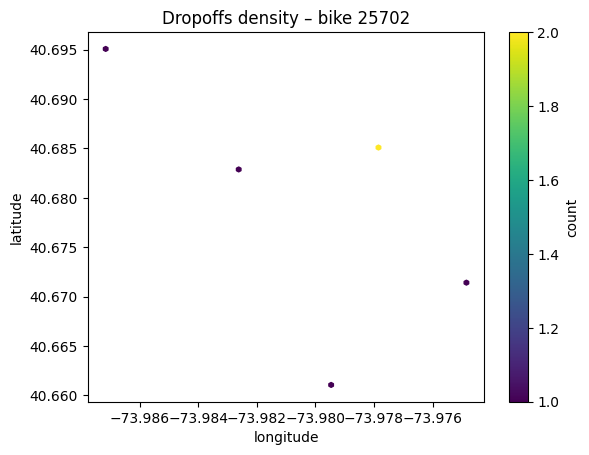

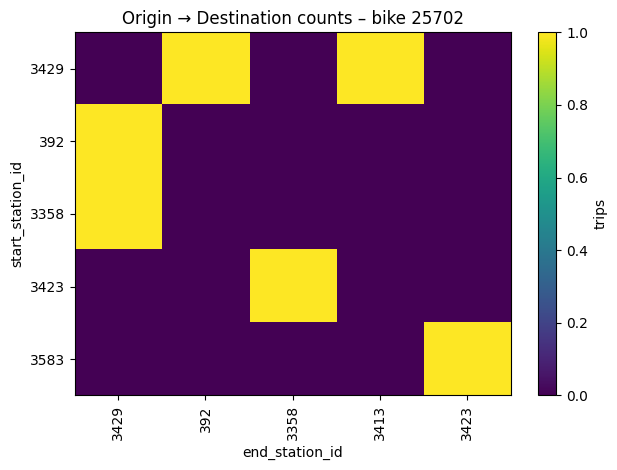

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tmp = df[['bikeid','tripduration']].copy()
tmp['tripduration'] = pd.to_numeric(tmp['tripduration'], errors='coerce')
agg = (tmp.dropna()
         .groupby('bikeid', as_index=False)
         .agg(trips=('tripduration','size'), total=('tripduration','sum')))
bottom = (agg[agg['trips']>=5]
            .sort_values('total', ascending=True)
            .head(10)
            .copy())
bottom['rented_time'] = pd.to_timedelta(bottom['total'], unit='s')
print(bottom[['bikeid','trips','rented_time']].to_string(index=False))

bottom_bikes = bottom['bikeid'].tolist()
sub_all = df[df['bikeid'].isin(bottom_bikes)].copy()
for col in ['start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude','start_station_id','end_station_id']:
    sub_all[col] = pd.to_numeric(sub_all[col], errors='coerce')

for b in bottom_bikes:
    sub = sub_all[sub_all['bikeid'] == b]

    pick = sub.dropna(subset=['start_station_longitude','start_station_latitude'])
    if len(pick):
        plt.figure()
        plt.hexbin(pick['start_station_longitude'], pick['start_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Pickups density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    drop = sub.dropna(subset=['end_station_longitude','end_station_latitude'])
    if len(drop):
        plt.figure()
        plt.hexbin(drop['end_station_longitude'], drop['end_station_latitude'], gridsize=80, mincnt=1)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Dropoffs density – bike {b}')
        plt.colorbar(label='count')
        plt.show()

    od = (sub.dropna(subset=['start_station_id','end_station_id'])
            .groupby(['start_station_id','end_station_id'])
            .size()
            .unstack(fill_value=0))
    if not od.empty:
        r = od.sum(axis=1).nlargest(min(25, len(od))).index
        c = od.sum(axis=0).nlargest(min(25, od.shape[1])).index
        od_top = od.loc[r, c]
        plt.figure()
        plt.imshow(od_top.values, aspect='auto', interpolation='nearest')
        plt.xticks(np.arange(od_top.shape[1]), od_top.columns.astype(int), rotation=90)
        plt.yticks(np.arange(od_top.shape[0]), od_top.index.astype(int))
        plt.title(f'Origin → Destination counts – bike {b}')
        plt.colorbar(label='trips')
        plt.xlabel('end_station_id')
        plt.ylabel('start_station_id')
        plt.tight_layout()
        plt.show()


detect dead-zones (spots where bike are left and not picked up for a ride in a long time)

prev_end_station_id  events  total_idle_hours  median_idle_min  mean_idle_min        lat        lon
252              3255.0   21677     510756.986871       859.738583    1413.729723  40.750585 -73.994685
777               514.0   13666     370554.985884       950.041875    1626.906129  40.760875 -74.002777
241              3236.0   11545     224626.105485       823.166250    1167.394225  40.758985 -73.993800
759               492.0   10042     206089.608787       893.435742    1231.365916  40.750200 -73.990931
291              3312.0    5823     164756.393052      1016.916433    1697.644442  40.781721 -73.945940
185              3140.0    9201     161181.117306       849.134317    1051.066953  40.771404 -73.953517
220              3173.0    7763     157364.978641       884.410200    1216.269318  40.777507 -73.988886
719               445.0    8824     154379.527717       832.476308    1049.724803  40.727408 -73.981420
565              3599.0    3779     142429.219471      1320.476867    2261.379510  40.663140 -73.960569
25               2009.0    6423     139955.191369       917.915700    1307.381517  40.711174 -73.996826
356              3374.0    5835     139573.372210      1034.811250    1435.201771  40.799484 -73.955613
211              3165.0    5632     137089.937542      1020.658133    1460.475187  40.775794 -73.976206
496              3534.0    4999     133839.470794      1022.540233    1606.394929  40.805159 -73.954692
212              3166.0    6589     132885.230360       870.975267    1210.064323  40.780578 -73.985624
510              3547.0    3841     131649.876020      1206.596983    2056.493768  40.814326 -73.959025
273              3296.0    4040     131495.309381      1107.948467    1952.900634  40.782454 -73.948920
595               363.0    6204     131151.949993       922.044158    1268.394101  40.708347 -74.017134
145               310.0    4103     130381.651867      1314.036133    1906.629079  40.689269 -73.989129
283              3305.0    6161     128525.848983       891.024667    1251.671959  40.781122 -73.949656
349              3368.0    4890     125105.625922       996.049158    1535.038355  40.672816 -73.983524
369              3389.0    3925     124937.711090      1050.212517    1909.875838  40.683046 -74.003486
353              3371.0    2954     124934.899333      1379.451400    2537.607976  40.674613 -73.985011
85               3016.0    4495     119191.104514      1119.045950    1590.982485  40.720368 -73.961651
504              3541.0    2333     116916.876409      1531.060100    3006.863517  40.813358 -73.956461
372              3391.0    2479     114861.435466      1344.391133    2780.026675  40.789253 -73.939562

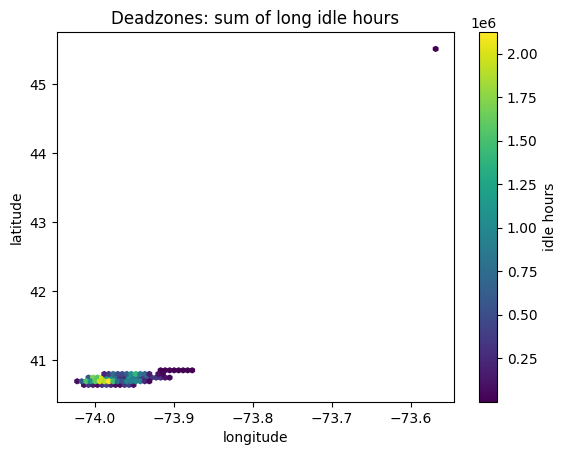

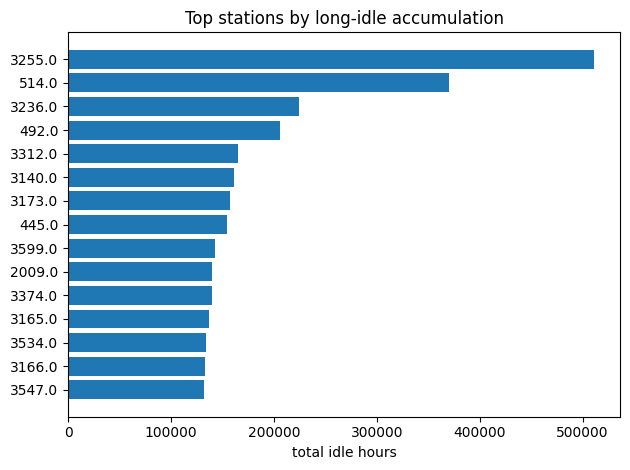

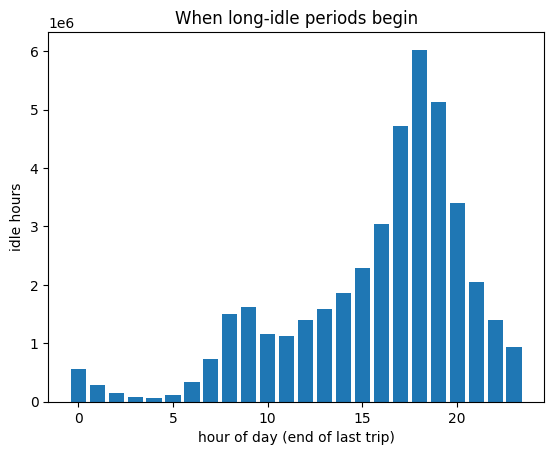

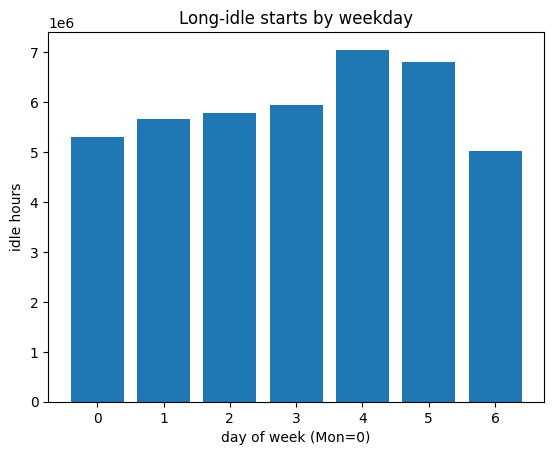

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

station_distance_km = 0.2
min_idle_minutes = 360
min_events_for_table = 10

cols = ['bikeid','starttime','stoptime','start_station_id','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']
g = df[cols].copy()
g['starttime'] = pd.to_datetime(g['starttime'], errors='coerce')
g['stoptime'] = pd.to_datetime(g['stoptime'], errors='coerce')
for c in ['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']:
    g[c] = pd.to_numeric(g[c], errors='coerce')
g['start_station_id'] = g['start_station_id'].astype(str)
g['end_station_id'] = g['end_station_id'].astype(str)

g = g.sort_values(['bikeid','starttime'])
g['prev_stoptime'] = g.groupby('bikeid')['stoptime'].shift(1)
g['prev_end_station_id'] = g.groupby('bikeid')['end_station_id'].shift(1)
g['prev_end_lat'] = g.groupby('bikeid')['end_station_latitude'].shift(1)
g['prev_end_lon'] = g.groupby('bikeid')['end_station_longitude'].shift(1)

pairs = g.dropna(subset=['starttime','prev_stoptime'])
pairs = pairs[pairs['starttime'] >= pairs['prev_stoptime']]
pairs['idle_min'] = (pairs['starttime'] - pairs['prev_stoptime']).dt.total_seconds()/60.0
pairs['same_station'] = pairs['start_station_id'] == pairs['prev_end_station_id']

geo = pairs.dropna(subset=['prev_end_lat','prev_end_lon','start_station_latitude','start_station_longitude'])
geo['dist_km'] = haversine(geo['prev_end_lat'].values, geo['prev_end_lon'].values,
                           geo['start_station_latitude'].values, geo['start_station_longitude'].values)
stalls = geo[(geo['same_station']) & (geo['dist_km'] <= station_distance_km)]

q = stalls['idle_min'].quantile([0.5,0.75,0.9,0.95,0.99]).to_dict()
thr = max(min_idle_minutes, stalls['idle_min'].quantile(0.9))
stalls_long = stalls[stalls['idle_min'] >= thr].copy()
stalls_long['idle_hours'] = stalls_long['idle_min']/60.0

s_agg = (stalls_long
         .groupby('prev_end_station_id', as_index=False)
         .agg(events=('idle_hours','size'),
              total_idle_hours=('idle_hours','sum'),
              median_idle_min=('idle_min','median'),
              mean_idle_min=('idle_min','mean'),
              lat=('prev_end_lat','median'),
              lon=('prev_end_lon','median'))
         .sort_values('total_idle_hours', ascending=False))
display(s_agg[s_agg['events']>=min_events_for_table].head(25))

plt.figure()
plt.hexbin(stalls_long['prev_end_lon'], stalls_long['prev_end_lat'],
           C=stalls_long['idle_hours'], gridsize=80, reduce_C_function=np.sum, mincnt=1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Deadzones: sum of long idle hours')
plt.colorbar(label='idle hours')
plt.show()

s_top = s_agg.head(15)
plt.figure()
plt.barh(s_top['prev_end_station_id'].astype(str), s_top['total_idle_hours'])
plt.gca().invert_yaxis()
plt.xlabel('total idle hours')
plt.title('Top stations by long-idle accumulation')
plt.tight_layout()
plt.show()

stalls_long['prev_hour'] = stalls_long['prev_stoptime'].dt.hour
stalls_long['prev_dow'] = stalls_long['prev_stoptime'].dt.dayofweek
h = stalls_long.groupby('prev_hour')['idle_hours'].sum()
plt.figure()
plt.bar(h.index.astype(int), h.values)
plt.xlabel('hour of day (end of last trip)')
plt.ylabel('idle hours')
plt.title('When long-idle periods begin')
plt.show()

d = stalls_long.groupby('prev_dow')['idle_hours'].sum()
plt.figure()
plt.bar(d.index.astype(int), d.values)
plt.xlabel('day of week (Mon=0)')
plt.ylabel('idle hours')
plt.title('Long-idle starts by weekday')
plt.show()


metric         value
0              days_covered  3.650000e+02
1               total_trips  1.754834e+07
2              bikes_active  1.524400e+04
3     bikes_lt5_trips_share  6.231960e-03
4              avg_trip_min  1.647905e+01
5           median_trip_min  1.008333e+01
6              p90_trip_min  2.760000e+01
7             trips_per_day  4.807764e+04
8  avg_daily_hours_per_bike  1.857451e+00

Top utilization bikes (mean daily hours, trips, active_days)


bikeid  mean_daily_hours  trips  active_days  trips_per_day
0   35591        247.683981     15            3       5.000000
1   24939         85.072884    185           34       5.441176
2   30503         49.829370    747          112       6.669643
3   30875         36.370696    819          127       6.448819
4   18504         35.680173    549          109       5.036697
5   25788         35.660884    399           66       6.045455
6   31347         34.287574    368           94       3.914894
7   27413         34.218644    309           50       6.180000
8   16777         33.221124    531          131       4.053435
9   19957         32.797651    592          103       5.747573

Bottom utilization bikes (>=5 trips)


bikeid  mean_daily_hours  trips  active_days  trips_per_day
0   28253          0.157454     11            6       1.833333
1   34508          0.160278      6            4       1.500000
2   34889          0.161806      5            4       1.250000
3   31906          0.163333     11            6       1.833333
4   21341          0.196806      5            2       2.500000
5   28984          0.220556      6            4       1.500000
6   34549          0.223704      5            3       1.666667
7   34502          0.224815      8            6       1.333333
8   34887          0.253403      8            4       2.000000
9   34624          0.262130      8            6       1.333333

Top exporter stations (net pickups > dropoffs)


station_id        lat        lon  net_out  net_out_daily  volume_daily
0      3164.0  40.777057 -73.978985  17197.0      47.115068    326.424658
1       281.0  40.764397 -73.973715  10093.0      27.652055    402.780822
2      3161.0  40.780184 -73.977285   6992.0      19.156164    151.282192
3       391.0  40.697601 -73.993446   6809.0      18.654795    142.961644
4      3283.0  40.788221 -73.970416   6214.0      17.024658    138.175342
5       399.0  40.688515 -73.964763   5640.0      15.452055     75.084932
6      3226.0  40.782750 -73.971370   5581.0      15.290411    142.183562
7       356.0  40.716226 -73.982612   5463.0      14.967123     95.136986
8       432.0  40.726218 -73.983799   5297.0      14.512329    332.742466
9      3295.0  40.791270 -73.964839   5173.0      14.172603    185.750685
10     3163.0  40.773407 -73.977825   5058.0      13.857534    254.608219
11     3158.0  40.771639 -73.982614   4556.0      12.482192    237.561644
12     3177.0  40.786795 -73.977112   4263.0      11.679452    124.873973
13     3418.0  40.675021 -73.971115   4086.0      11.194521     97.567123
14      532.0  40.710451 -73.960876   3967.0      10.868493    196.583562

Top importer stations (net dropoffs > pickups)


station_id        lat        lon  net_out  net_out_daily  volume_daily
0       324.0  40.689888 -73.981013 -11942.0     -32.717808    153.972603
1       445.0  40.727408 -73.981420  -7296.0     -19.989041    376.323288
2       217.0  40.702772 -73.993836  -6991.0     -19.153425    189.947945
3       304.0  40.704633 -74.013617  -6650.0     -18.219178    261.994521
4       426.0  40.717548 -74.013221  -4957.0     -13.580822    531.202740
5       301.0  40.722174 -73.983688  -4542.0     -12.443836    233.594521
6       497.0  40.737050 -73.990093  -4453.0     -12.200000    608.819178
7      3232.0  40.689622 -73.983043  -3819.0     -10.463014    128.473973
8       243.0  40.688226 -73.979382  -3760.0     -10.301370     76.224658
9       402.0  40.740343 -73.989551  -3542.0      -9.704110    588.361644
10      458.0  40.751396 -74.005226  -3504.0      -9.600000    319.057534
11      459.0  40.746745 -74.007756  -3477.0      -9.526027    423.378082
12     3472.0  40.742754 -74.007474  -3451.0      -9.454795    216.019178
13      377.0  40.722438 -74.005664  -3358.0      -9.200000    233.408219
14     3016.0  40.720368 -73.961651  -3147.0      -8.621918    233.953425

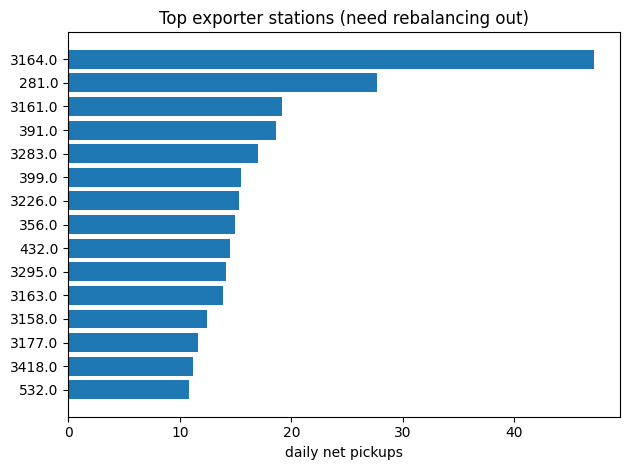

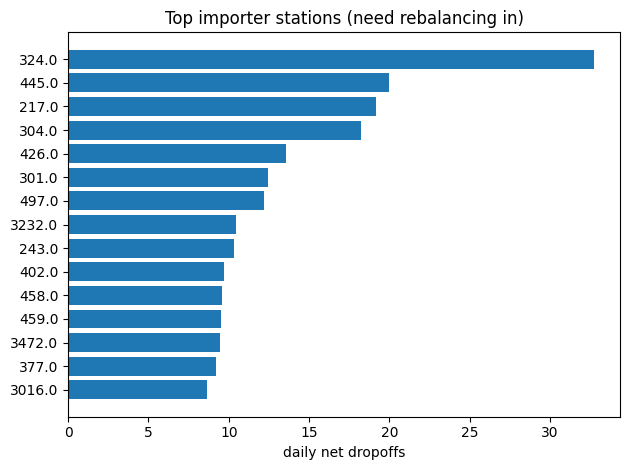

Top O→D corridors by trips


start_station_id end_station_id  trips  distance_km    avg_dur_s  avg_speed_kmh
11944            2006.0         2006.0   7852     0.000000  2754.247326       0.000000
291063            432.0         3263.0   7249     0.691231   273.474134       9.099326
37781             281.0          281.0   6344     0.000000  3925.630044       0.000000
12112            2006.0         3282.0   6215     2.383001  1554.703298       5.517968
304346            460.0         3093.0   5456     0.805678   297.393328       9.752881
69108            3093.0          460.0   5137     0.805678   350.436442       8.276655
292656            435.0          509.0   4996     0.779830   299.953763       9.359406
334240            519.0          492.0   4663     1.129438   510.993352       7.957003
334246            519.0          498.0   4465     0.949167   422.102352       8.095197
272318            387.0          387.0   4464     0.000000  1885.154794       0.000000
29107             258.0          324.0   4340     1.026515   250.928571      14.727122
331034            514.0          426.0   4163     4.897410  1397.413164      12.616652
334239            519.0          491.0   4116     1.400821   434.710884      11.600713
242797            363.0         3002.0   4096     0.370618   251.591797       5.303128
314781            481.0         3093.0   4021     0.641790   195.730664      11.804209
151300           3351.0         3318.0   4004     0.574039   265.845155       7.773468
181643           3430.0         3086.0   3982     0.477645   207.052235       8.304782
305985            462.0          453.0   3907     0.512260   258.788073       7.126046
120817           3256.0          426.0   3880     1.141961   582.332474       7.059642
321333            494.0         3258.0   3879     0.522537   228.938902       8.216748

High average-speed corridors (data quality check)


start_station_id end_station_id  trips  distance_km  avg_dur_s  avg_speed_kmh
244378           3635.0          308.0     10     4.628084      445.1      37.432265
62567             308.0         3635.0      9     4.628084      331.0      50.335653
347317             82.0         3635.0      2     4.849642      206.5      84.545818
129620           3295.0         3180.0      2    10.637908      613.5      62.422935
260956           3690.0         3635.0      2     4.743391      251.5      67.897440
257583           3683.0          492.0      2     4.485325      218.5      73.900096
257582           3683.0          477.0      2     5.163626      402.5      46.183986
244649           3635.0         3690.0      1     4.743391      340.0      50.224136
336448            524.0         3683.0      1     5.018260      401.0      45.051707
332735            517.0         3683.0      1     4.640105      250.0      66.817511
318247            487.0         3040.0      1     7.227773      471.0      55.244127
296436            442.0         3683.0      1     4.134022      362.0      41.111817
257590           3683.0          528.0      1     3.696183      334.0      39.839098
257578           3683.0          450.0      1     5.802048      589.0      35.462431
257571           3683.0          379.0      1     4.377418      270.0      58.365569
251413           3660.0         3040.0      1     7.937904      409.0      69.869082
39331             285.0         3040.0      1     7.208300      661.0      39.258518
47137            3040.0          366.0      1     3.412268      335.0      36.669148
224763           3571.0          498.0      1     8.555930      422.0      72.988978
210884           3533.0         3180.0      1    13.093224      253.0     186.306749

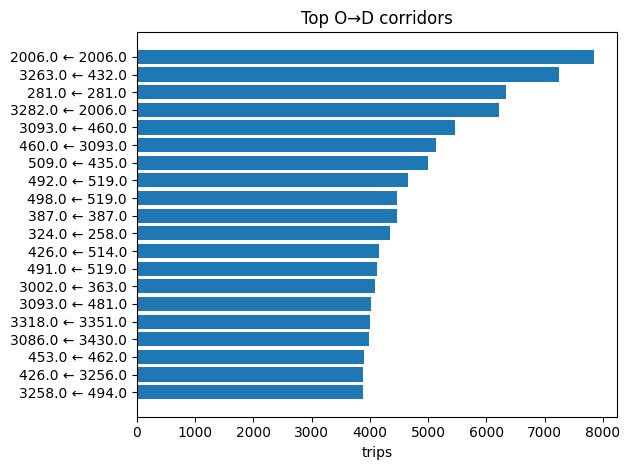

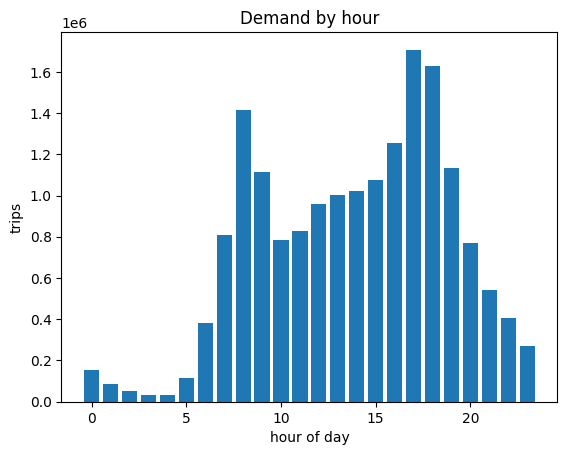

Greedy nightly rebalancing suggestions (avg moves/day)


from_station_id to_station_id  daily_moves  distance_km
17           391.0         217.0    15.536986     0.575856
2            432.0         445.0    10.953425     0.240171
45           399.0         324.0    10.635616     1.378603
60           281.0         402.0     9.704110     2.988875
59          3158.0         458.0     9.600000     2.948430
75          3164.0        3472.0     9.454795     4.506340
96          3161.0         377.0     9.200000     6.851629
41           339.0        3016.0     8.621918     1.220059
5            469.0        3443.0     7.926027     0.336391
22           356.0         301.0     7.734247     0.667573
68          3159.0         459.0     7.528767     3.779471
3            433.0         445.0     7.326027     0.249048
80          3349.0         304.0     6.665753     5.038068
0            239.0         324.0     6.501370     0.232305
87          3164.0         229.0     6.350685     5.657046
70          3163.0         168.0     6.290411     4.003060
73          3165.0         497.0     6.104110     4.464106
39           517.0         492.0     6.060274     1.107527
12           266.0         150.0     5.802740     0.532036
48           356.0         414.0     5.775342     1.550359
94          3160.0        3467.0     5.591781     6.450605
15           281.0         520.0     5.506849     0.549539
97          3161.0        3664.0     5.468493     7.227004
28           314.0        3232.0     5.389041     0.786387
99          3162.0         426.0     5.369863     7.811217
34           420.0         324.0     5.301370     0.986824
20           262.0         243.0     5.273973     0.619252
78          3164.0         382.0     5.230137     4.811368
38           487.0         236.0     5.057534     1.094883
77          3164.0         496.0     4.904110     4.566852

Peak vs off-peak mix


period     share
0  off_peak  0.574068
1      peak  0.425932

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

cols = ['bikeid','tripduration','starttime','stoptime','start_station_id','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']
g = df[cols].copy()
g['tripduration'] = pd.to_numeric(g['tripduration'], errors='coerce')
g['starttime'] = pd.to_datetime(g['starttime'], errors='coerce')
g['stoptime'] = pd.to_datetime(g['stoptime'], errors='coerce')
for c in ['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']:
    g[c] = pd.to_numeric(g[c], errors='coerce')
g['start_station_id'] = g['start_station_id'].astype(str)
g['end_station_id'] = g['end_station_id'].astype(str)
g = g.dropna(subset=['tripduration','starttime'])
g = g[g['tripduration']>0]

days_covered = int((g['starttime'].max().normalize() - g['starttime'].min().normalize()).days) + 1

btrips = g.groupby('bikeid').size().rename('trips')
bdaily = g.assign(date=g['starttime'].dt.date).groupby(['bikeid','date'])['tripduration'].sum().div(3600.0).rename('hours').reset_index()
butil = bdaily.groupby('bikeid')['hours'].agg(mean_daily_hours='mean', median_daily_hours='median', active_days='count').join(btrips)
butil['trips_per_day'] = butil['trips']/butil['active_days']
butil_good = butil[butil['trips']>=5]
top_bikes = butil_good.nlargest(10, 'mean_daily_hours').reset_index()
bottom_bikes = butil_good.nsmallest(10, 'mean_daily_hours').reset_index()

starts = g.groupby('start_station_id')[['start_station_latitude','start_station_longitude']].median().rename(columns={'start_station_latitude':'lat','start_station_longitude':'lon'})
ends = g.groupby('end_station_id')[['end_station_latitude','end_station_longitude']].median().rename(columns={'end_station_latitude':'lat','end_station_longitude':'lon'})
coords = starts.combine_first(ends)

pick = g.groupby('start_station_id').size().rename('pickups')
drop = g.groupby('end_station_id').size().rename('dropoffs')
station = pd.DataFrame(index=coords.index).join([coords, pick, drop]).fillna(0)
station['net_out'] = station['pickups'] - station['dropoffs']
station['volume'] = station['pickups'] + station['dropoffs']
station['net_out_daily'] = station['net_out']/days_covered
station['volume_daily'] = station['volume']/days_covered

exporters = station[station['net_out']>0].nlargest(15, 'net_out').reset_index().rename(columns={'index':'station_id'})
importers = station[station['net_out']<0].nsmallest(15, 'net_out').reset_index().rename(columns={'index':'station_id'})
display(pd.DataFrame({'metric':['days_covered','total_trips','bikes_active','bikes_lt5_trips_share','avg_trip_min','median_trip_min','p90_trip_min','trips_per_day','avg_daily_hours_per_bike'], 
                      'value':[days_covered, int(len(g)), g['bikeid'].nunique(), float((btrips<5).mean()), float(g['tripduration'].mean()/60.0), float(g['tripduration'].median()/60.0), float(g['tripduration'].quantile(0.9)/60.0), round(len(g)/days_covered,2), float(butil['mean_daily_hours'].mean())]}))
print('Top utilization bikes (mean daily hours, trips, active_days)')
display(top_bikes[['bikeid','mean_daily_hours','trips','active_days','trips_per_day']])
print('Bottom utilization bikes (>=5 trips)')
display(bottom_bikes[['bikeid','mean_daily_hours','trips','active_days','trips_per_day']])
print('Top exporter stations (net pickups > dropoffs)')
display(exporters[['station_id','lat','lon','net_out','net_out_daily','volume_daily']])
print('Top importer stations (net dropoffs > pickups)')
display(importers[['station_id','lat','lon','net_out','net_out_daily','volume_daily']])

plt.figure()
plt.barh(exporters['station_id'].astype(str), exporters['net_out_daily'])
plt.gca().invert_yaxis()
plt.xlabel('daily net pickups')
plt.title('Top exporter stations (need rebalancing out)')
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(importers['station_id'].astype(str), -importers['net_out_daily'])
plt.gca().invert_yaxis()
plt.xlabel('daily net dropoffs')
plt.title('Top importer stations (need rebalancing in)')
plt.tight_layout()
plt.show()

od = g.groupby(['start_station_id','end_station_id']).agg(trips=('tripduration','size'), avg_dur_s=('tripduration','mean')).reset_index()
od = od[(od['start_station_id']!= 'nan') & (od['end_station_id']!='nan')]
od = od.merge(coords.rename(columns={'lat':'s_lat','lon':'s_lon'}), left_on='start_station_id', right_index=True, how='left')
od = od.merge(coords.rename(columns={'lat':'e_lat','lon':'e_lon'}), left_on='end_station_id', right_index=True, how='left')
od = od.dropna(subset=['s_lat','s_lon','e_lat','e_lon'])
od['distance_km'] = haversine(od['s_lat'].values, od['s_lon'].values, od['e_lat'].values, od['e_lon'].values)
od['avg_speed_kmh'] = od['distance_km']/(od['avg_dur_s']/3600.0)
corridors = od.sort_values('trips', ascending=False).head(20)
speed_anom = od[od['avg_speed_kmh']>35].sort_values('trips', ascending=False).head(20)
print('Top O→D corridors by trips')
display(corridors[['start_station_id','end_station_id','trips','distance_km','avg_dur_s','avg_speed_kmh']])
print('High average-speed corridors (data quality check)')
display(speed_anom[['start_station_id','end_station_id','trips','distance_km','avg_dur_s','avg_speed_kmh']])

plt.figure()
plt.barh(corridors['end_station_id'].astype(str)+' ← '+corridors['start_station_id'].astype(str), corridors['trips'])
plt.gca().invert_yaxis()
plt.xlabel('trips')
plt.title('Top O→D corridors')
plt.tight_layout()
plt.show()

h = g['starttime'].dt.hour.value_counts().sort_index()
plt.figure()
plt.bar(h.index.astype(int), h.values)
plt.xlabel('hour of day')
plt.ylabel('trips')
plt.title('Demand by hour')
plt.show()

station_exp = station[station['net_out']>0].nlargest(60, 'net_out').copy()
station_imp = station[station['net_out']<0].nsmallest(60, 'net_out').copy()
station_exp['surplus'] = station_exp['net_out_daily'].clip(lower=0)
station_imp['need'] = (-station_imp['net_out_daily']).clip(lower=0)
exp = station_exp[['surplus','lat','lon']].copy()
imp = station_imp[['need','lat','lon']].copy()
exp.index = station_exp.index
imp.index = station_imp.index
plan = []
while len(exp) and len(imp) and len(plan)<200:
    d = haversine(exp['lat'].values[:,None], exp['lon'].values[:,None], imp['lat'].values[None,:], imp['lon'].values[None,:])
    i,j = np.unravel_index(np.argmin(d), d.shape)
    e_id = exp.index[i]; m_id = imp.index[j]
    move = float(min(exp.iloc[i,0], imp.iloc[j,0]))
    if move<=0:
        break
    plan.append((e_id, m_id, move, float(d[i,j])))
    exp.iloc[i,0] -= move
    imp.iloc[j,0] -= move
    if exp.iloc[i,0] <= 1e-6:
        exp = exp.drop(exp.index[i])
    if imp.iloc[j,0] <= 1e-6:
        imp = imp.drop(imp.index[j])
rebal = pd.DataFrame(plan, columns=['from_station_id','to_station_id','daily_moves','distance_km']).sort_values(['daily_moves','distance_km'], ascending=[False, True]).head(30)
print('Greedy nightly rebalancing suggestions (avg moves/day)')
display(rebal)

peak = g.assign(dow=g['starttime'].dt.dayofweek, hr=g['starttime'].dt.hour)
peak['is_peak'] = ((peak['dow']<=4) & (peak['hr'].isin([7,8,9,16,17,18,19]))).astype(int)
print('Peak vs off-peak mix')
display(peak['is_peak'].value_counts(normalize=True).rename({0:'off_peak',1:'peak'}).rename_axis('period').reset_index(name='share'))
